In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import pprint

from fusiondls.geometry import *
from fusiondls.SOLPSreader import read_balance

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = read_balance(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)
                
            params["Xpoint"] = df[df["Xpoint"]==1].index[0]

            geom = MagneticGeometry(params["Bpol"], params["Btot"], params["R"], params["Z"], params["Spar"], params["Spol"], params["Xpoint"])

            
            eqb_alt[case][region][i] = geom
            
            # eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Cooling curve work

In [5]:
# rd_N = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")
rd_Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

## ADAS interpolation

In [6]:
rd_Ar.coords["dim_ne_tau"].values

array([1.e+15, 5.e+15, 1.e+16, 5.e+16, 1.e+17, 5.e+17, 1.e+18, 5.e+18])

Text(0.5, 1.0, 'Interpolated N curves')

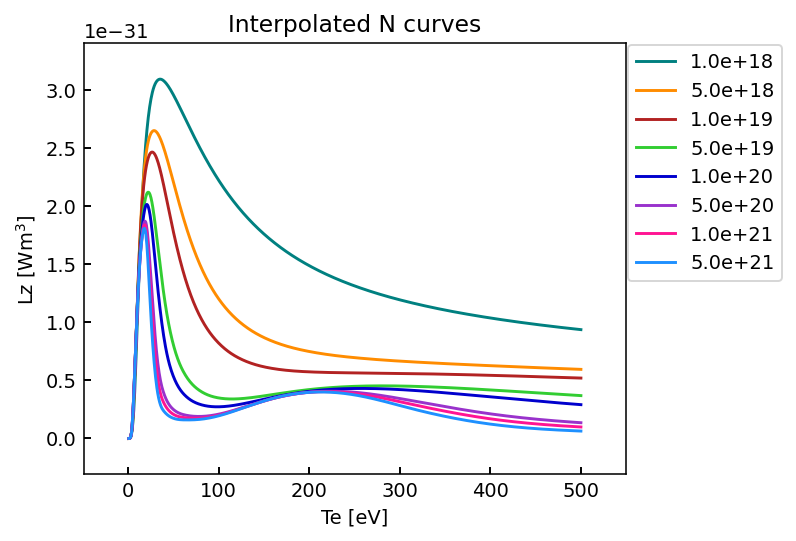

In [7]:
curves = {}
curves["Ar"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau * 1000 # Convert to ms
    curves["Ar"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )

temps_interp = np.linspace(1, 500, 1000)

fig, ax = plt.subplots()
for netau in curves["Ar"].keys():
    ax.plot(temps_interp, [curves["Ar"][netau](T) for T in temps_interp], label = f"{netau:.1e}")
    
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
# ax.set_xlim(0,2)
# ax.set_ylim(0,1e-35)
# ax.set_yscale("log")
ax.set_xlabel("Te [eV]")
ax.set_ylabel("Lz [$Wm^{3}$]")
ax.set_title("Interpolated N curves")

### Paper plot - outer

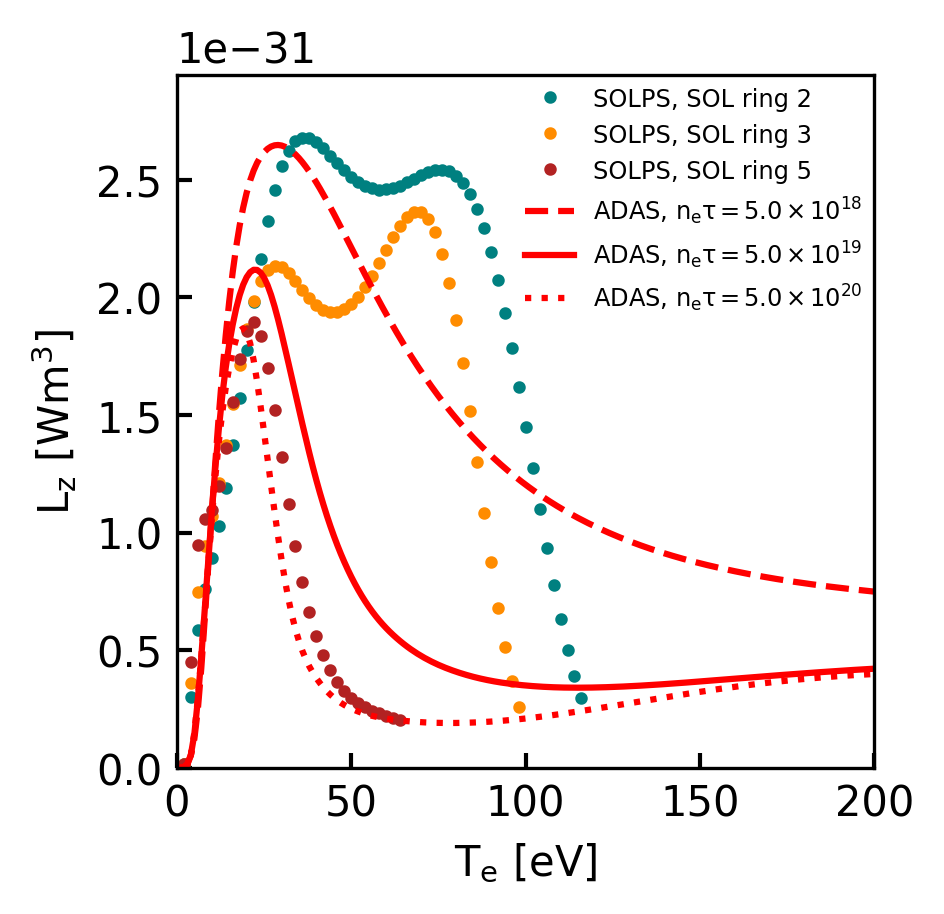

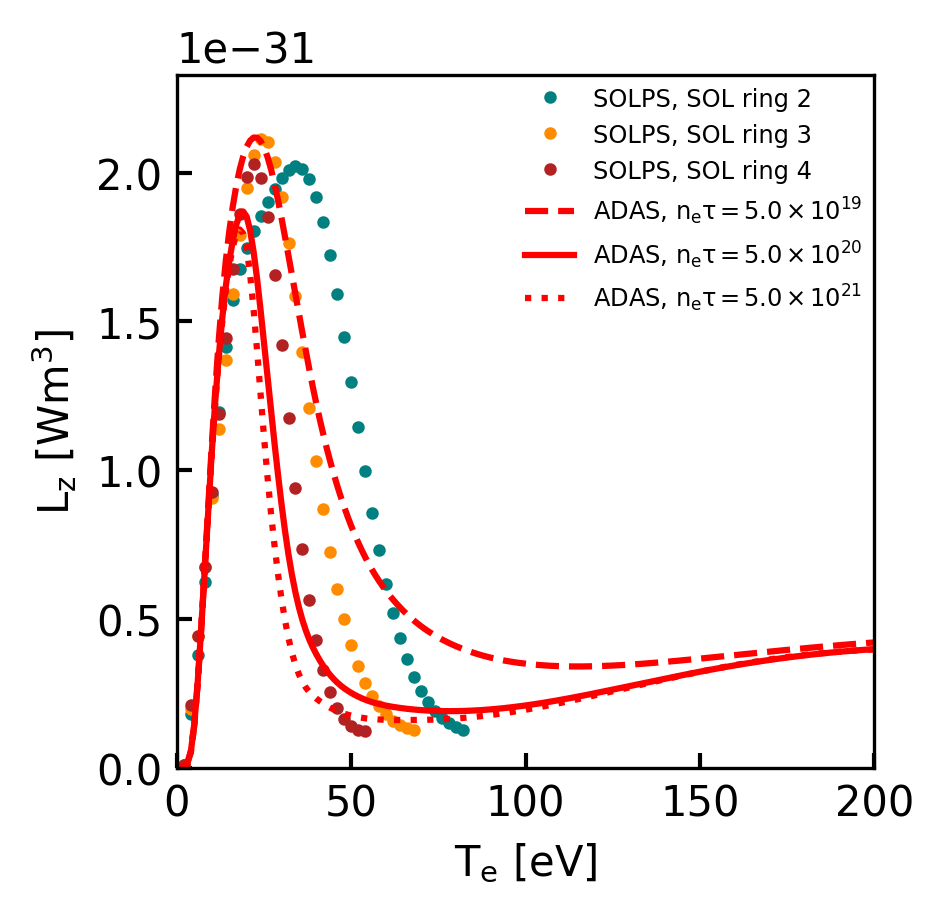

In [8]:
def sci_notation_latex(x):
    exponent = int(f"{x:.0e}".split('e')[1])
    mantissa = x / (10**exponent)
    return f"{mantissa}\\times 10^{{{exponent}}}"


ring_choice = dict(outer_lower = [1,2,4], inner_lower = [1,2,3])

for region in ["outer_lower", "inner_lower"]:
# for region in ["inner_lower"]:

    species = "Ar"

    fig, ax = plt.subplots(figsize = (3,3), dpi = 300)

    Tlo = 1
    Thi = 500

    T = np.linspace(Tlo, Thi, 500)

    df_curves = []
    for i in ring_choice[region]:
        slc = store_slc[case]
        fun = slc.extract_cooling_curve(species, region, sepadd = i, order = 9, plot = False)

        Lz = [fun(temp) for temp in T]
        
        df_curve = pd.DataFrame()
        df_curve["T"] = T
        df_curve["Lz"] = Lz
        df_curve = df_curve[df_curve["Lz"] > 0]
        df_curves.append(df_curve)
        ax.plot(df_curve["T"][::2], df_curve["Lz"][::2], marker = "o", ms = 2, lw = 0, label = "SOLPS, " + "SOL ring " + str(i+1))
        
    linestyles = ["--", "-", ":"]
    colors = ["red", "red", "red"]
    
    if "inner" in region:
        netau_choice = [5e19, 5e20, 5e21]
    elif "outer" in region:
        netau_choice = [5e18, 5e19, 5e20]

    for i, netau in enumerate(netau_choice):
        ax.plot(T, [curves["Ar"][netau](temp) for temp in T], label = rf"ADAS, $n_{{e}}\tau={sci_notation_latex(netau)}$", c = colors[i], lw = 1.5, ls = linestyles[i])
    ax.legend(loc = "upper right", ncols = 1, bbox_to_anchor=(1, 1), fontsize = "xx-small",  frameon = False)
    ax.set_xlim(0,200)
    ax.set_ylim(0,None)
    ax.set_xlabel("$T_e$ [eV]")
    ax.set_ylabel("$L_{z}$ [$Wm^{3}$]")
    ax.grid(which = "both", visible = False)
    # ax.set_title("Cross-case Lz comparison to ADAS")
    plt.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_coolingcurves_{region}.pdf", format = "pdf", bbox_inches = "tight")

# Choosing SOL ring

## Power balance

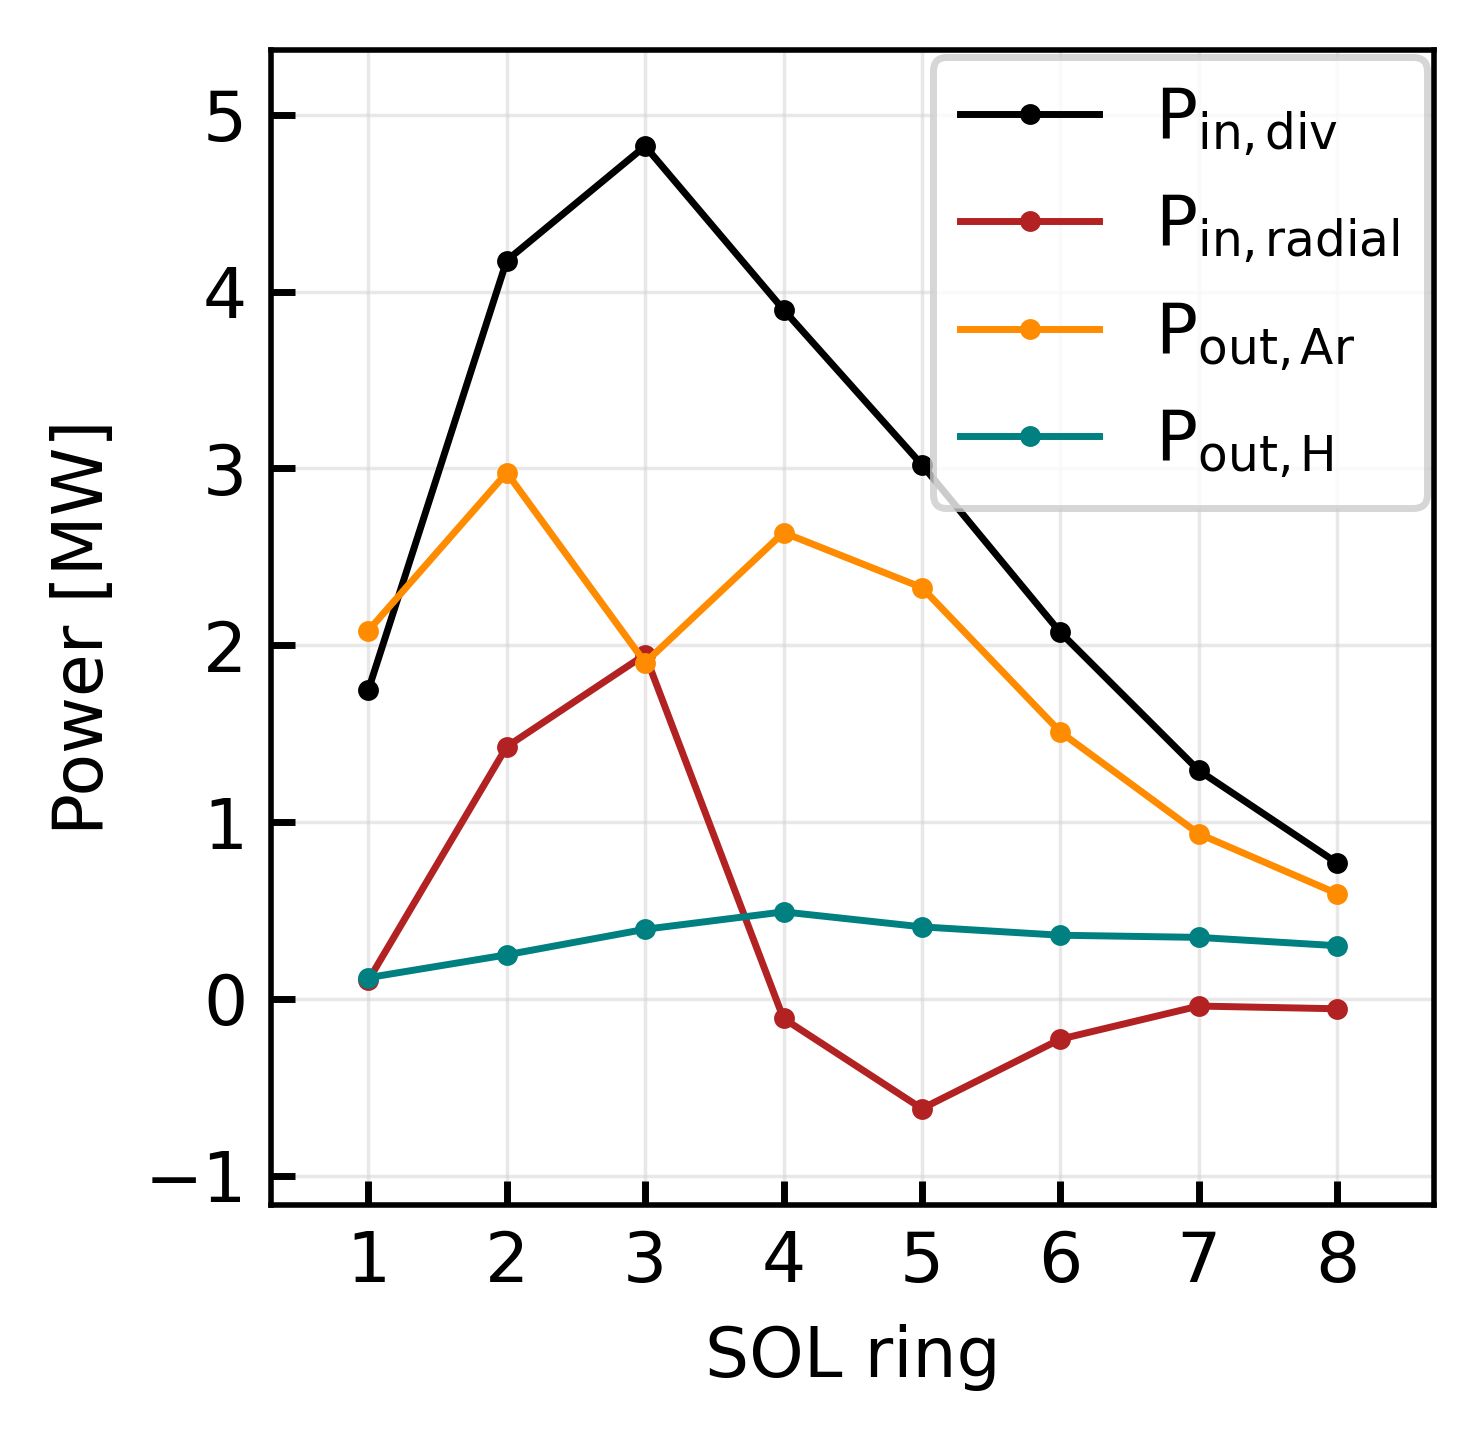

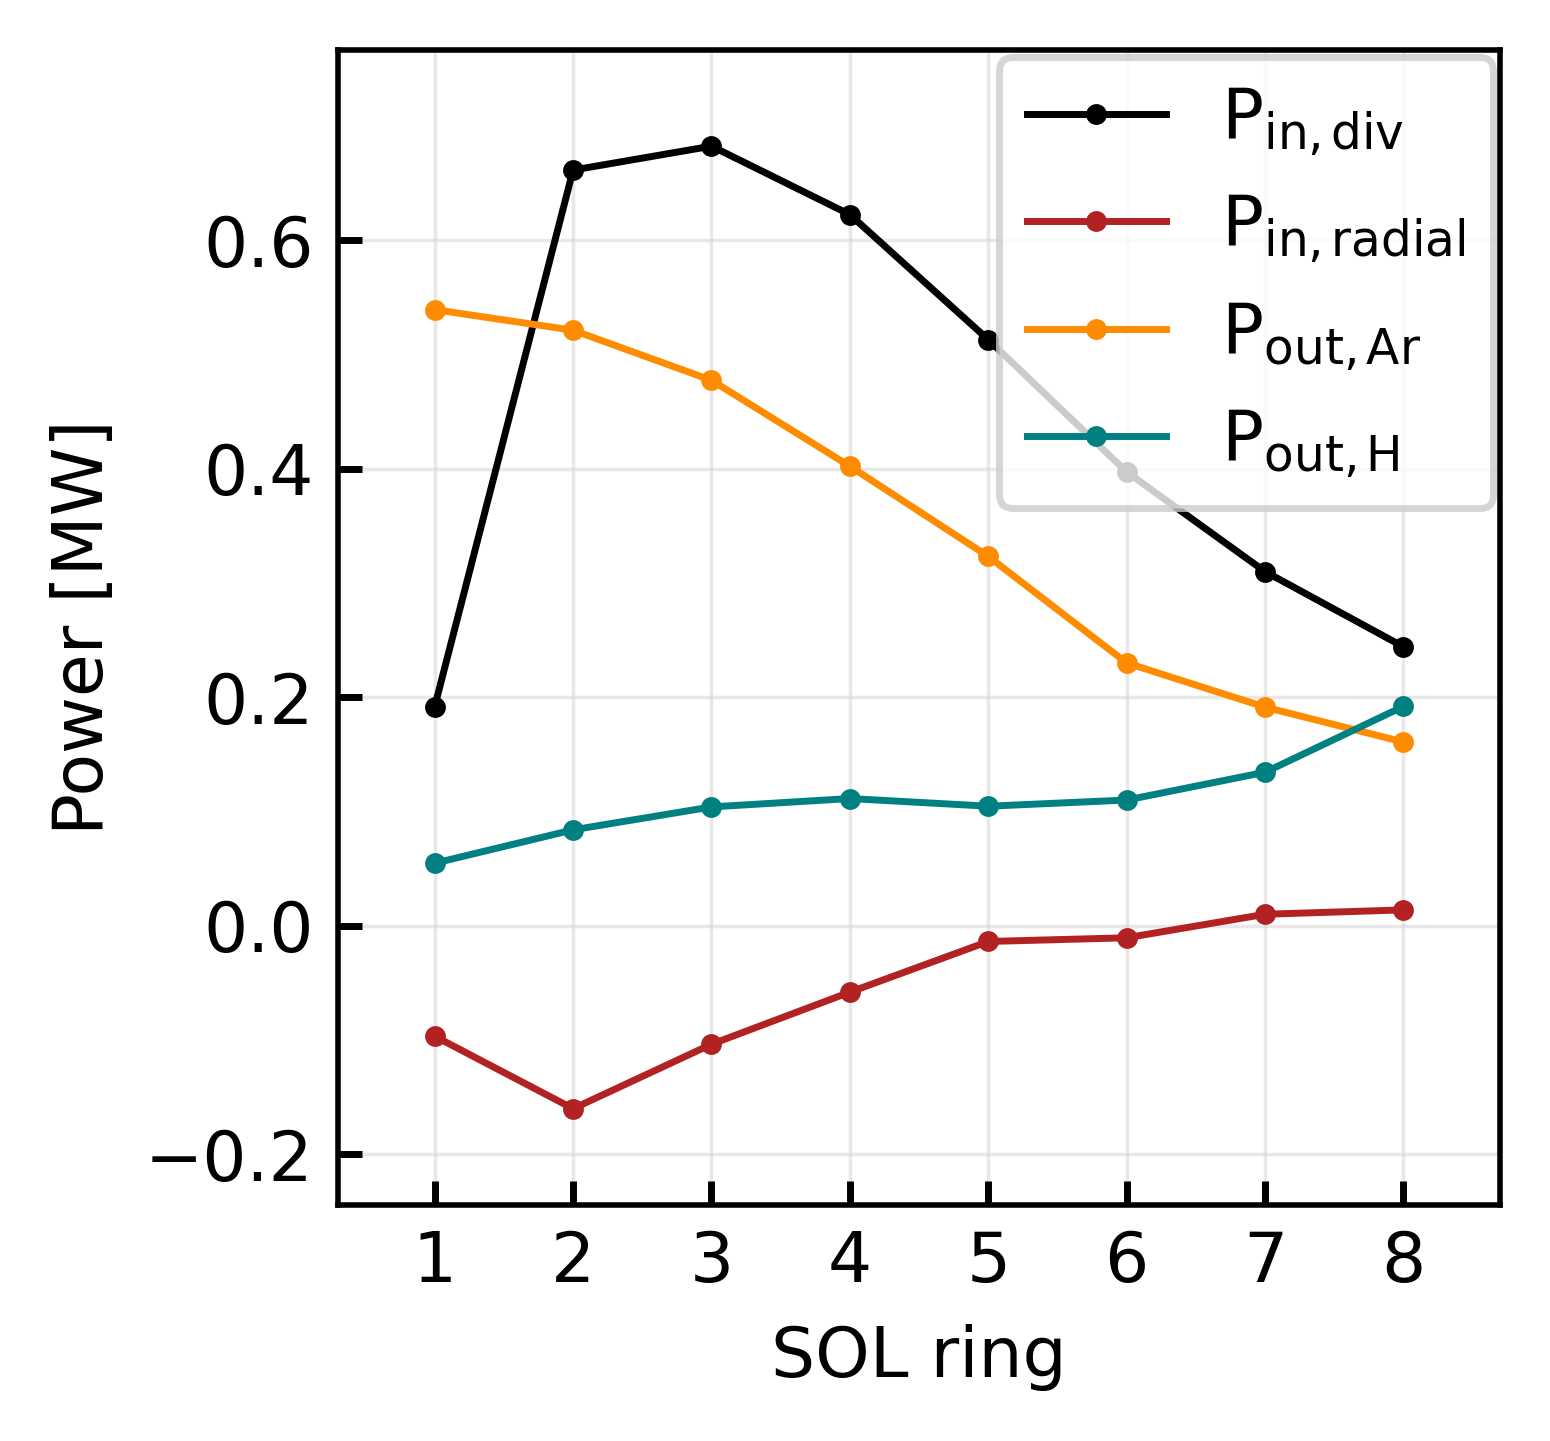

In [9]:
df = pd.DataFrame()

for region in ["outer_lower", "inner_lower"]:
    case = "100MW_innerar_midplanepuff"
    # case = "100MW_inner_arpuff"

    dfs = []
    for sepadd in range(8):
        baldict = store_slc[case].get_leg_energy_balance(
            sepadd = sepadd, region = region, impurities = ["Ar"], plot = False)
        df = pd.DataFrame.from_dict(baldict, orient = "index")
        df.columns = [sepadd+1]
        dfs.append(df)

    df = pd.concat(dfs, axis = 1).T
    df /= 1e6
    # df["Q_allsinks"] = df["Q_Ar"] + df["Q_H"] + df["Q_perp_out"]
    # df["P_radial"] = df["P_radial"].abs()
    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, abs(df["P_div"]), **style, c = "k",  label = r"$P_{in,div}$")
    ax.plot(df.index, df["P_radial"]*-1, **style, c = "firebrick", label = r"$P_{in,radial}$")
    ax.plot(df.index, df["P_Ar"], **style, c = "darkorange", label = r"$P_{out,Ar}$")
    ax.plot(df.index, df["P_H"], **style, c = "teal", label = r"$P_{out,H}$")
    

    # ax.plot(df.index, df["P_radial_e_bottom"], **style, c = "navy", label = r"$P_{out,radial,btm}$")
    # ax.plot(df.index, df["P_radial_e_top"], **style, c = "darkorange", label = r"$P_{out,radial,top}$")

    # df["P_allsinks"] = df["P_Ar"] + df["P_H"] + df["P_radial"]
    # ax.plot(df.index, df["P_allsinks"], c = "k", ls = ":", alpha = 0.5, label = "$P_{out,all}$")
    # ax2 = ax.twinx()
    # ax2.plot(df.index, df["qpar_mapped_to_target"], **style, ls = ":", c = "k", label = "$q_{\parallel,div}$")
    # ax2.set_ylabel("Heat flux [MW/$m^2$]")
    # ax2.grid(which = "both", visible = False)
    fig.legend(loc = "upper right", bbox_to_anchor = (0.9,0.88))
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Power [MW]")
    ax.grid(visible = True)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    plt.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_powerbalance_{region}.pdf", format = "pdf", bbox_inches = "tight")

## Particle balance

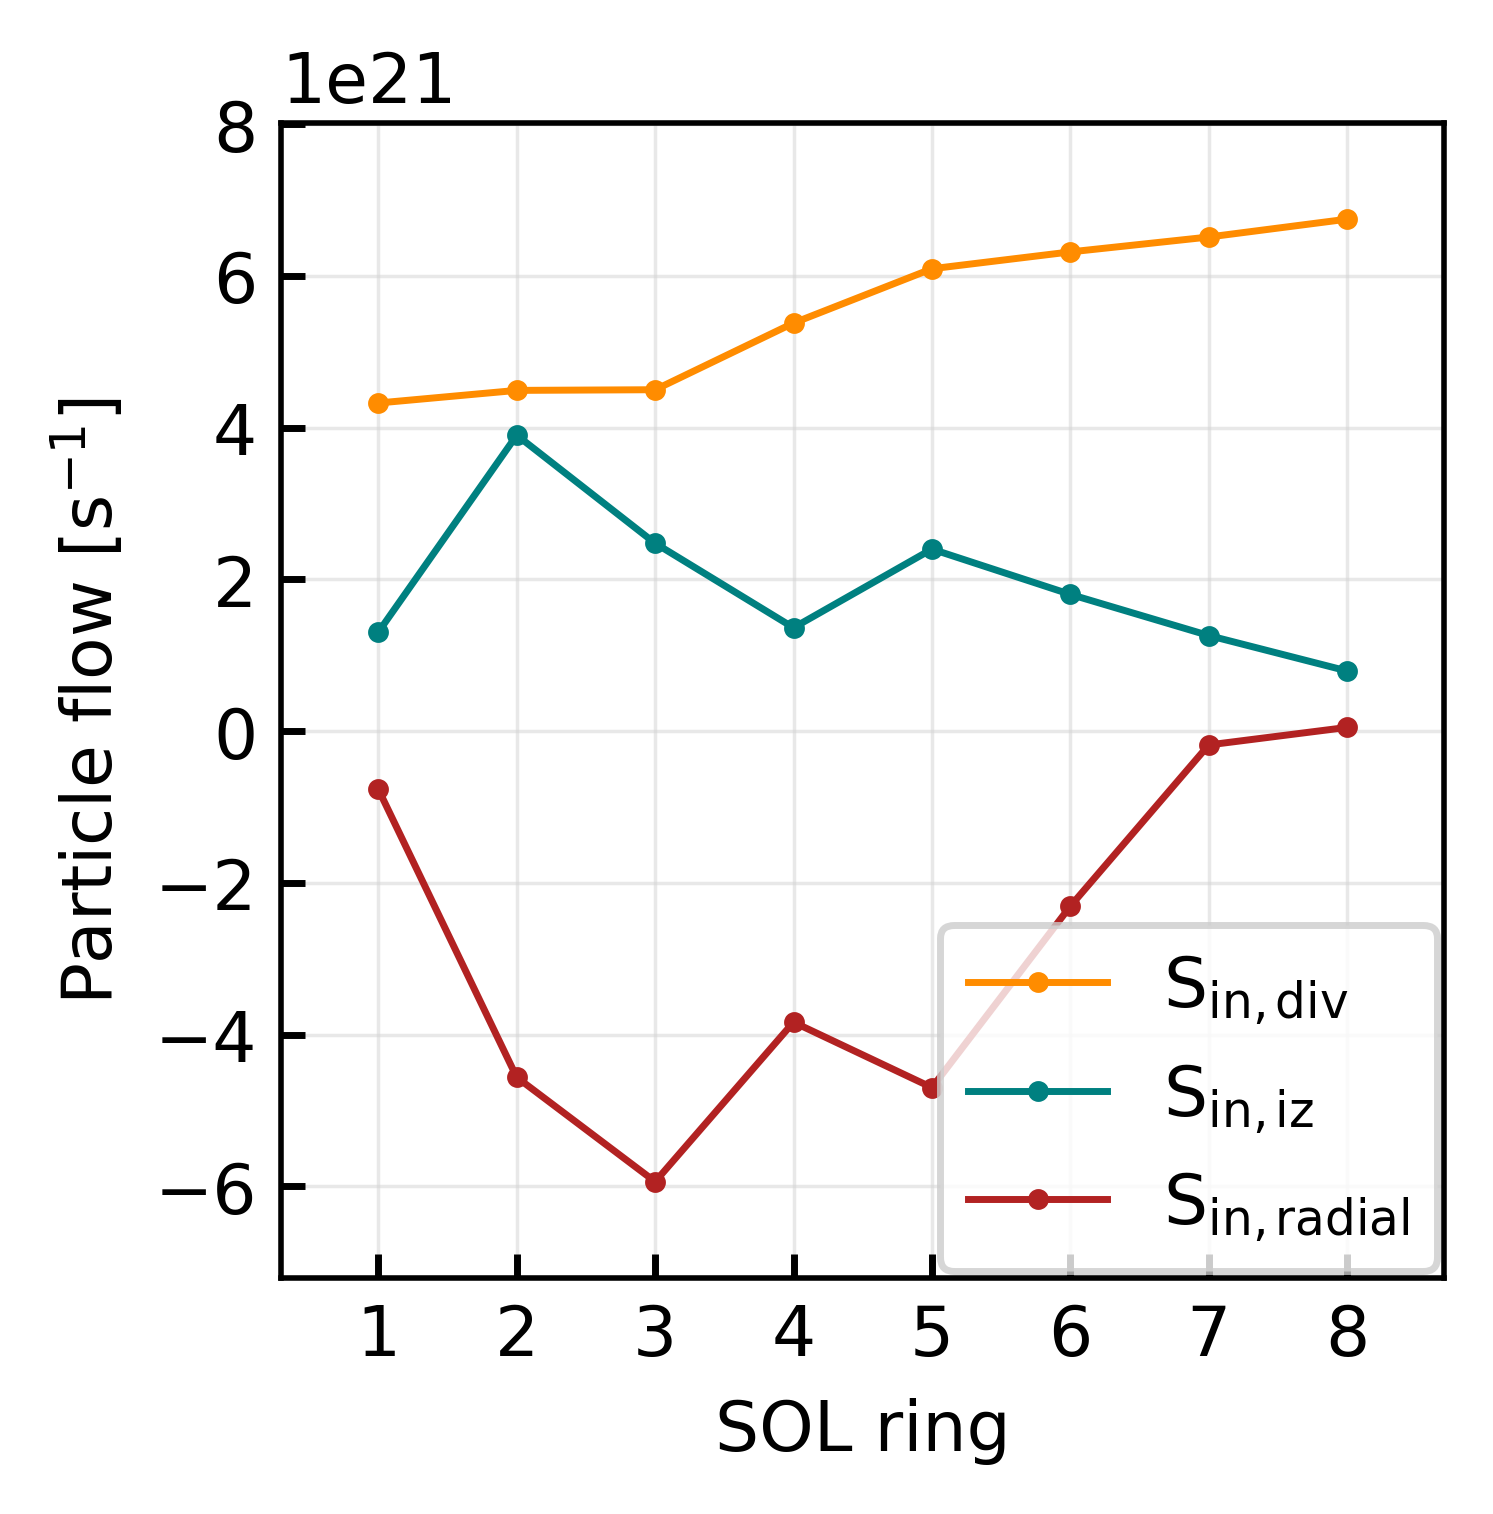

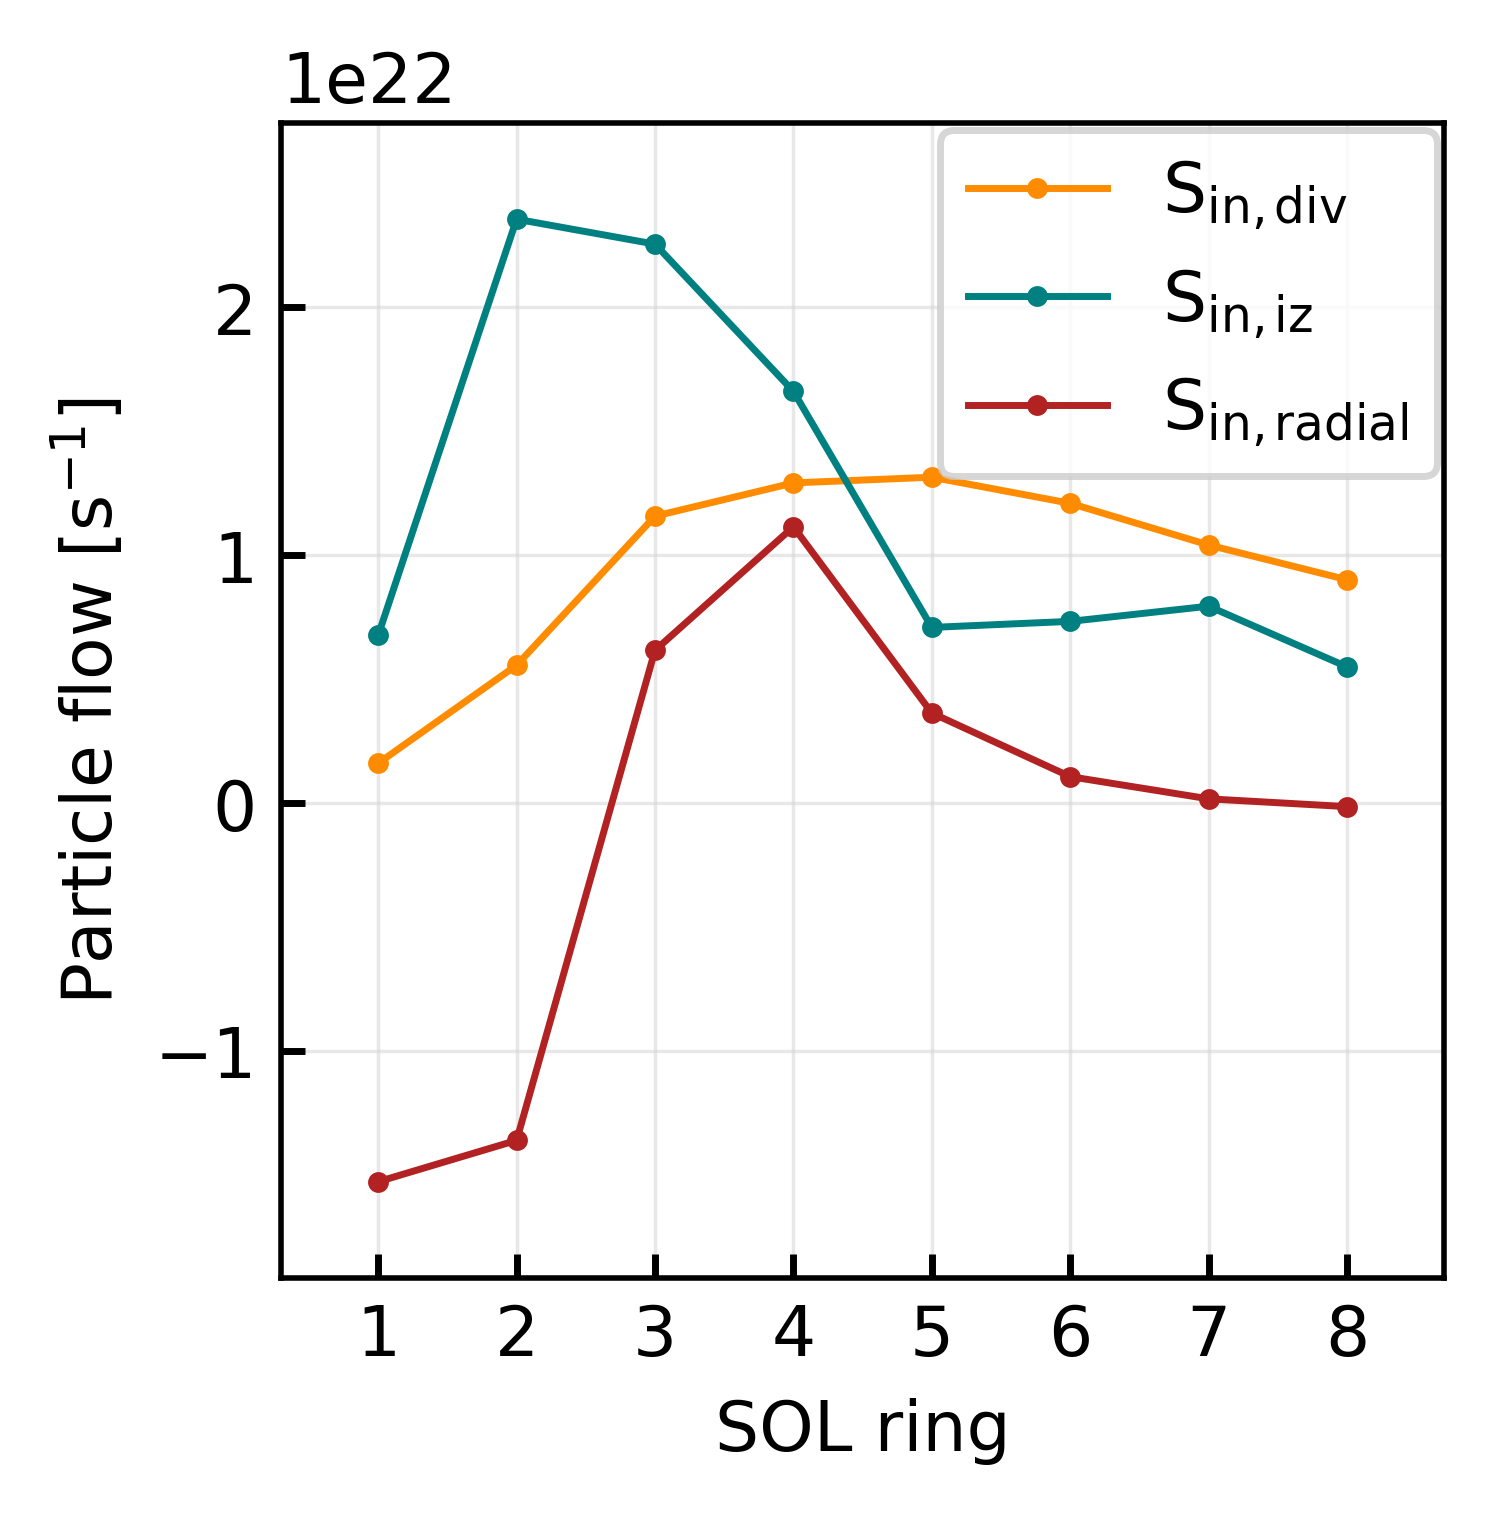

In [10]:
# for region in ["inner_lower", "outer_lower"]:
for region in ["inner_lower", "outer_lower"]:

    df = pd.DataFrame()
    # region = "outer_lower"
    case = "100MW_innerar_midplanepuff"

    dfs = []
    for sepadd in range(8):
        baldict = store_slc[case].get_leg_particle_balance(sepadd = sepadd, region = region, Te_threshold = 15)
        df = pd.DataFrame.from_dict(baldict, orient = "index")
        df.columns = [sepadd+1]
        dfs.append(df)

    df = pd.concat(dfs, axis = 1).T

    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, df["S_div"], **style, c = "darkorange",  label = r"$S_{in,div}$")
    ax.plot(df.index, df["S_iz"], **style, c = "teal", label = r"$S_{in,iz}$")
    ax.plot(df.index, -df["S_radial"], **style, c = "firebrick", label = r"$S_{in,radial}$")
    # ax.set_yscale("symlog")
    ax.legend()
    ax.grid(visible = True)
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Particle flow [$s^{-1}$]")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    plt.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_particlebalance_{region}.pdf", format = "pdf", bbox_inches = "tight")

## Peak heat flux

In [11]:
store_slc.keys()

dict_keys(['100MW_inner_arpuff', '100MW_innerar_midplanepuff'])

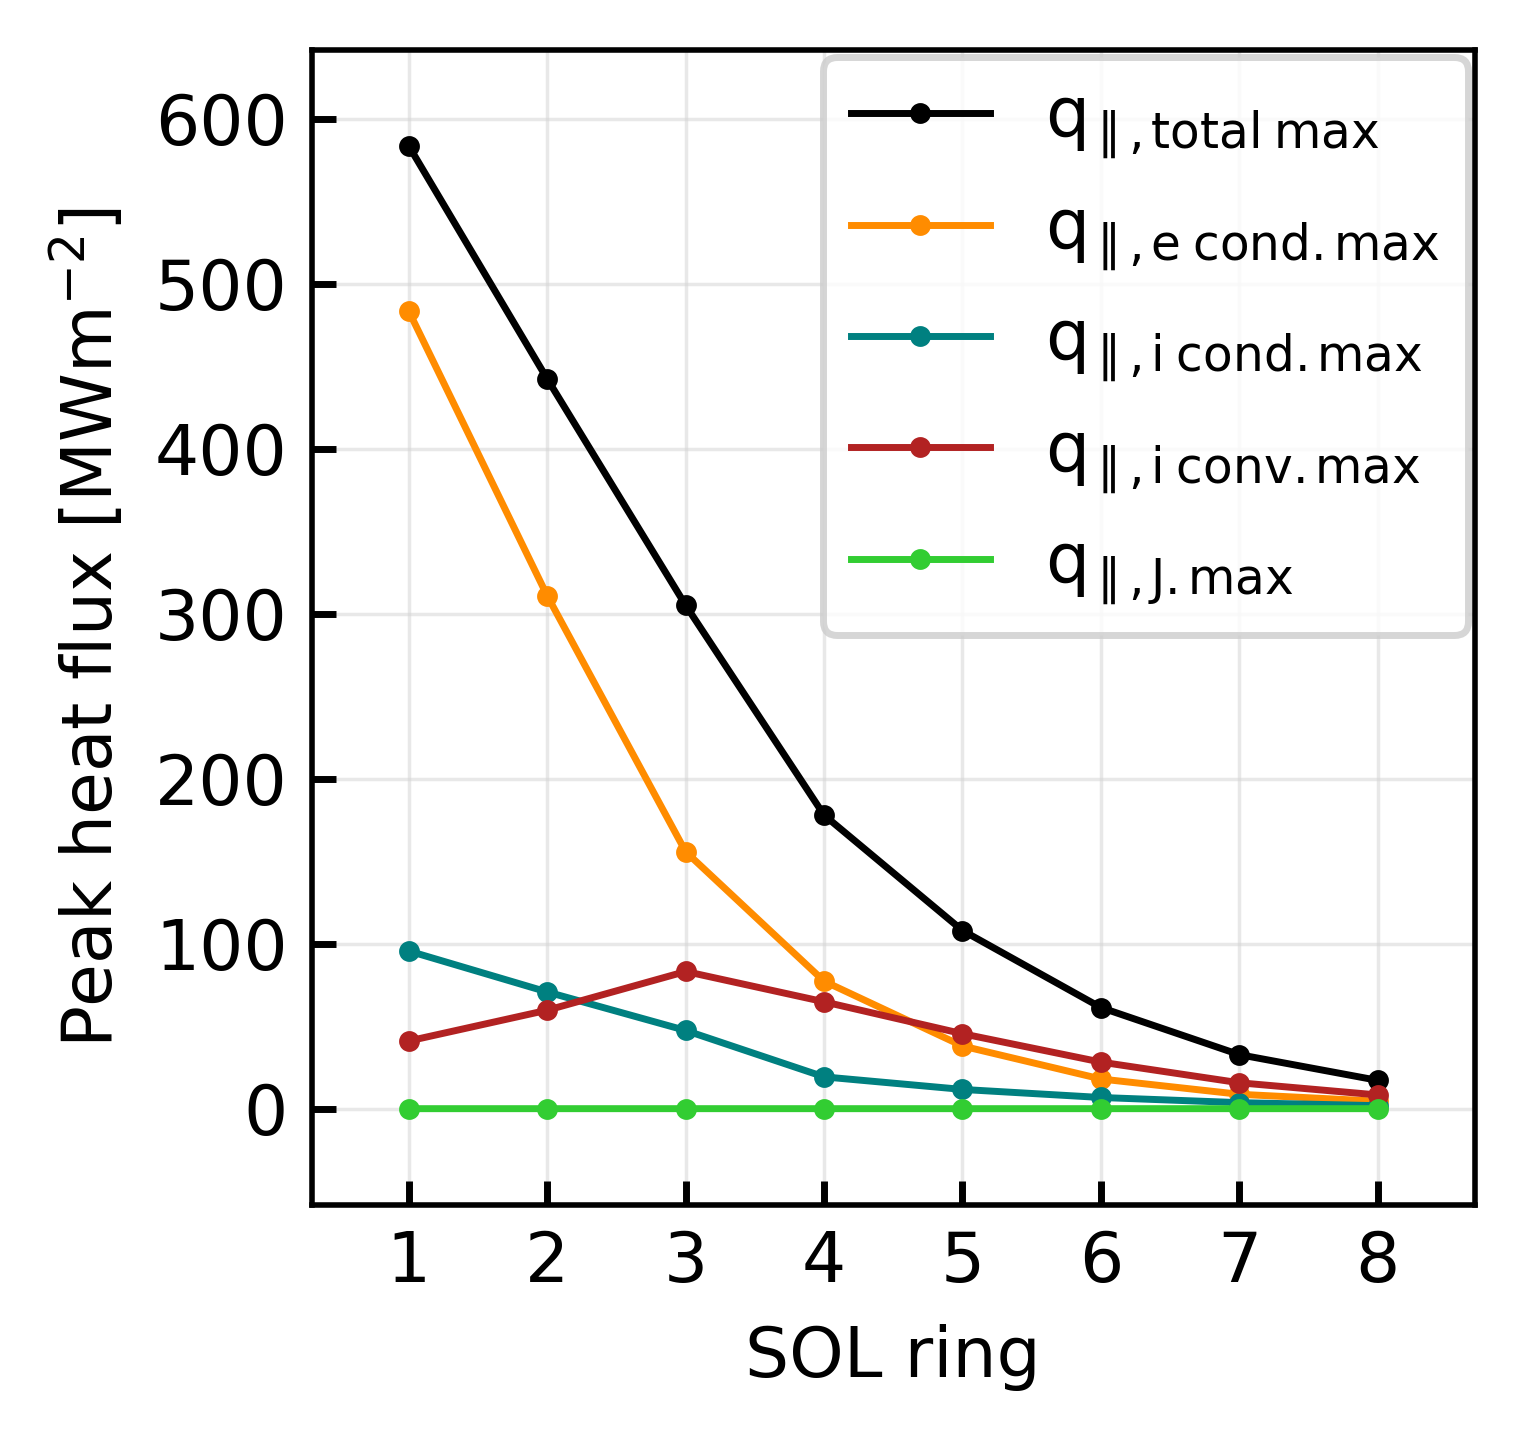

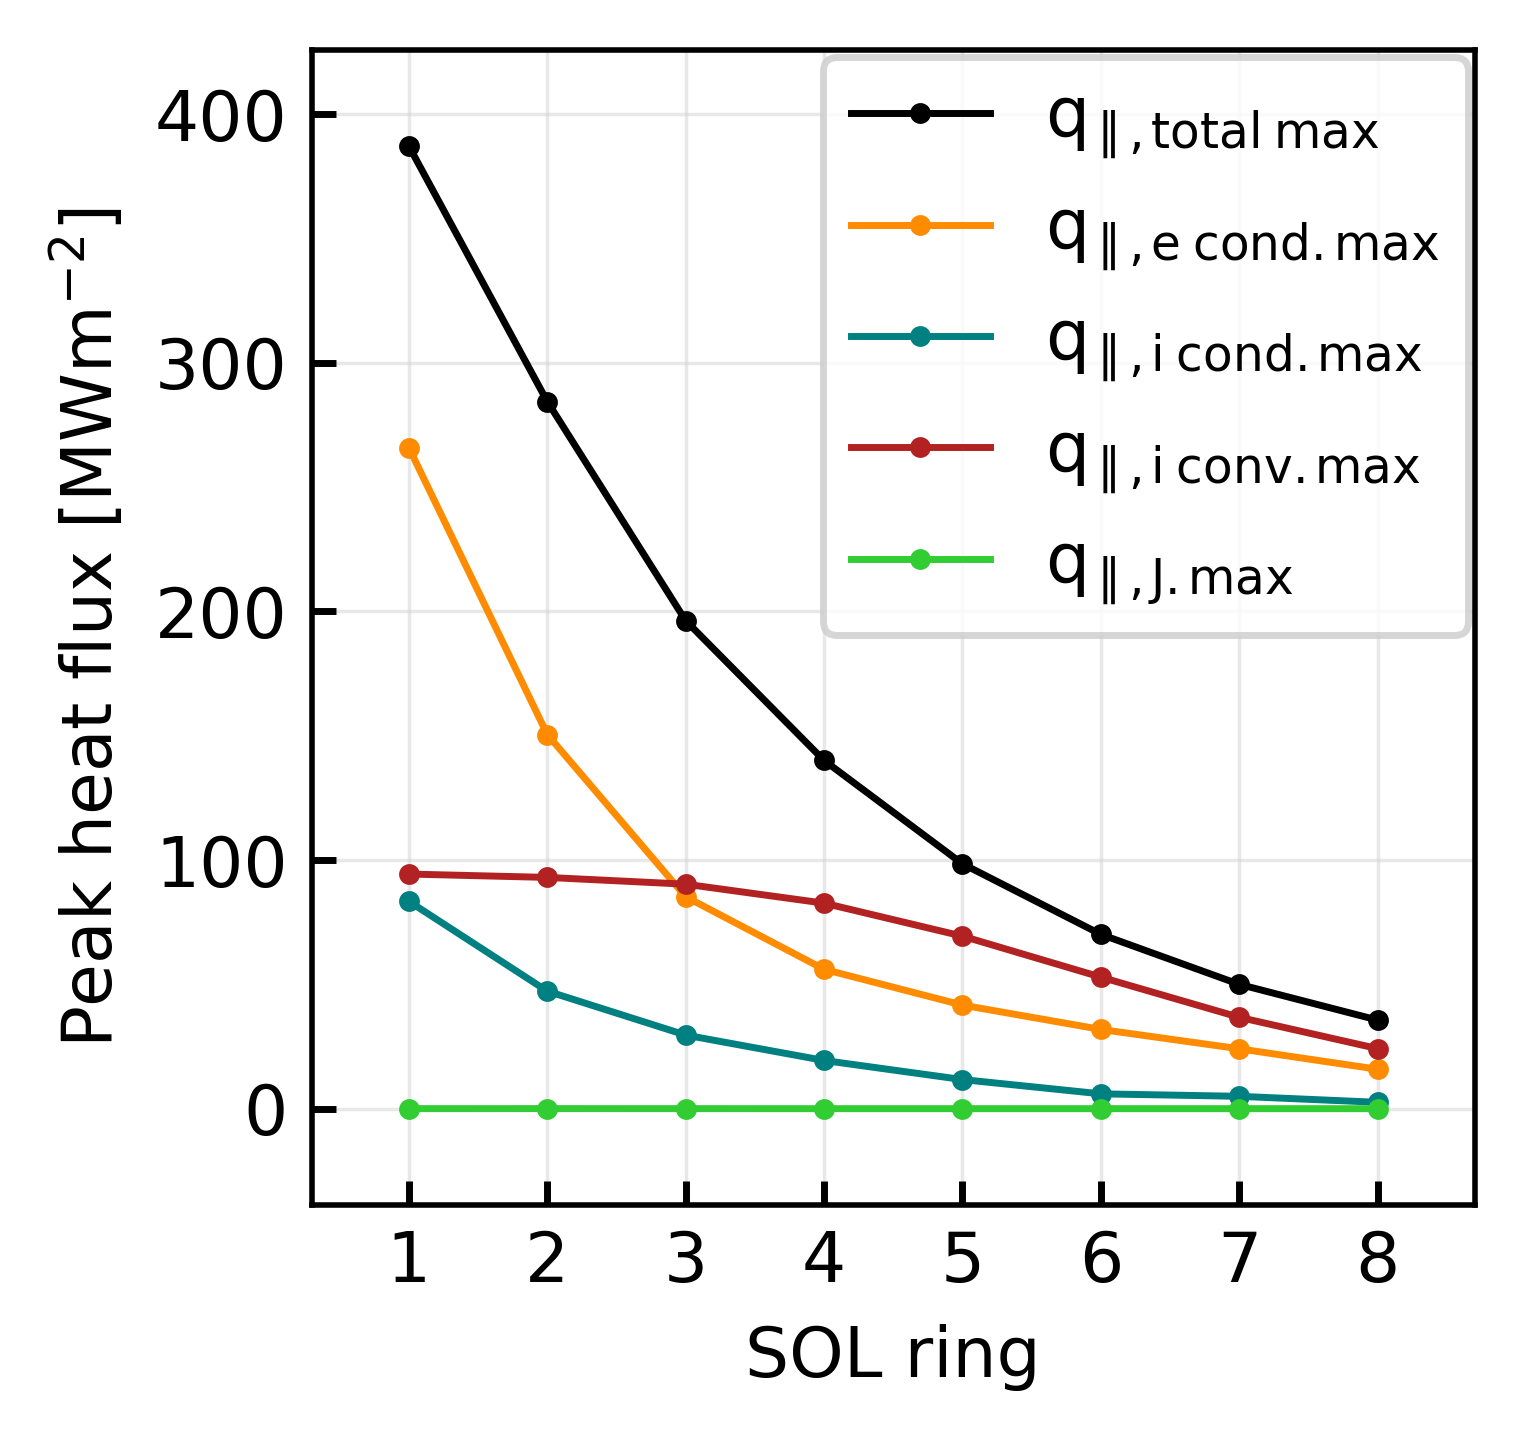

In [12]:
sepadd = 0
# region = "outer_lower"
# region = "inner_lower"
# case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'

for region in ["outer_lower", "inner_lower"]:
    df = pd.DataFrame()
    slc = store_slc[case]
    for sepadd in range(8):
        fline = slc.get_1d_poloidal_data(["Te", "RAr", "ne", "fhex_cond", "fhex_32", "fhix_cond", "fhix_32", "fhex_thermj", "fhx_total"], sepadd = sepadd, region = region, target_first = True)
        
        for param in ["fhex_32", "fhix_32"]:
            fline[param] = fline[param] * 5/3

        mult = -1 if "inner_lower" in region else 1
        
        for param in fline.columns:
            if param.startswith("fh"):
                fline[param] = fline[param] / fline["apar"]
                fline[param] *= mult
        solring = sepadd + 1
        df.loc[solring, "e_cond"] = fline["fhex_cond"].max()
        df.loc[solring, "i_cond"] = fline["fhix_cond"].max()
        df.loc[solring, "i_conv"] = fline["fhix_32"].max()
        df.loc[solring, "e_curr"] = fline["fhex_thermj"].max()
        df.loc[solring, "total"] = fline["fhx_total"].max()
        
        if fline["fhx_total"].mean() < 0:
            raise Exception("Total heat flux negative, fix sign")



    df /= 1e6
    # display(df)
    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, df["total"], **style, c = "k",  label = r"$q_{\parallel,total\ max}$")
    ax.plot(df.index, df["e_cond"], **style, c = "darkorange",  label = r"$q_{\parallel,e\ cond. max}$")
    ax.plot(df.index, df["i_cond"], **style, c = "teal", label = r"$q_{\parallel,i\ cond. max}$")
    ax.plot(df.index, df["i_conv"], **style, c = "firebrick", label = r"$q_{\parallel,i\ conv. max}$")
    ax.plot(df.index, df["e_curr"], **style, c = "limegreen", label = r"$q_{\parallel,J. max}$")

    ax.legend(fontsize = "medium")
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Peak heat flux [$MWm^{-2}$]")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.grid(visible = True)
    # plt.savefig(rf"C:\Users\Mike\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_heatfluxes_{region}.pdf", format = "pdf", bbox_inches = "tight")

# Outer target


## Setup


In [10]:
def run_DLS(custom_inputs, slc, cvar, region, sepadd, hflux_corr=1, return_comp = True):
    ## Get SOLPS field line and max qpar
    df = slc.get_1d_poloidal_data(
        params=["fhx_total", "Ne"], sepadd=sepadd, region=region, target_first=True
    )
    qpar_max = (df["fhx_total"] / df["apar"]).abs().max()

    ## Input deck
    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange=[
            slc.extract_front_pos(
                sepadd=sepadd,
                region=region,
                impurity="Ar",
                method="qpar_tot",
                threshold=0.05,
            )
        ],
        qpllu0=qpar_max * hflux_corr,
        nu0=df["Ne"].iloc[-1],
        cz0=0.05,
        cooling_curve=slc.extract_cooling_curve("Ar", region, sepadd=sepadd, plot=False),
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        grid_refinement_ratio=10,
        grid_refinement_width=1,
        grid_resolution=1000,
    )

    try:
        out = run_dls(
            dataclasses.replace(inputs, **custom_inputs),
            eqb_alt[case][region][sepadd],
            verbosity = 1
        )
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    if return_comp:
        return compare_SOLPS_DLS(
            slc, out, cvar, impurity="Ar", region=region, sepadd=sepadd
        )
    else:
        return out


def get_correction_factors(comp):
    fhx_solps = comp.solps[comp.solps["Xpoint"] == 1]["fhx_total"].abs().values[0]
    fhx_dls = comp.dls[comp.dls["Xpoint"] == 1]["qpar"].values[0]
    hflux_factor = fhx_solps / fhx_dls

    kappa_factor = (comp.dls["Te"].max() / comp.solps["Te"].max()) ** 2

    return hflux_factor, kappa_factor

## Run selected SOL rings
- With and without fitted curve

In [11]:
comps_outer = {}

### Without fitted curve

Solving...0.68...Complete in 0.3 seconds
    Hflux factor for sepadd 1: 1.06
Solving...0.38...Complete in 0.9 seconds
    Hflux factor for sepadd 2: 1.05
Solving...0.37...Complete in 0.7 seconds
    Hflux factor for sepadd 4: 1.06


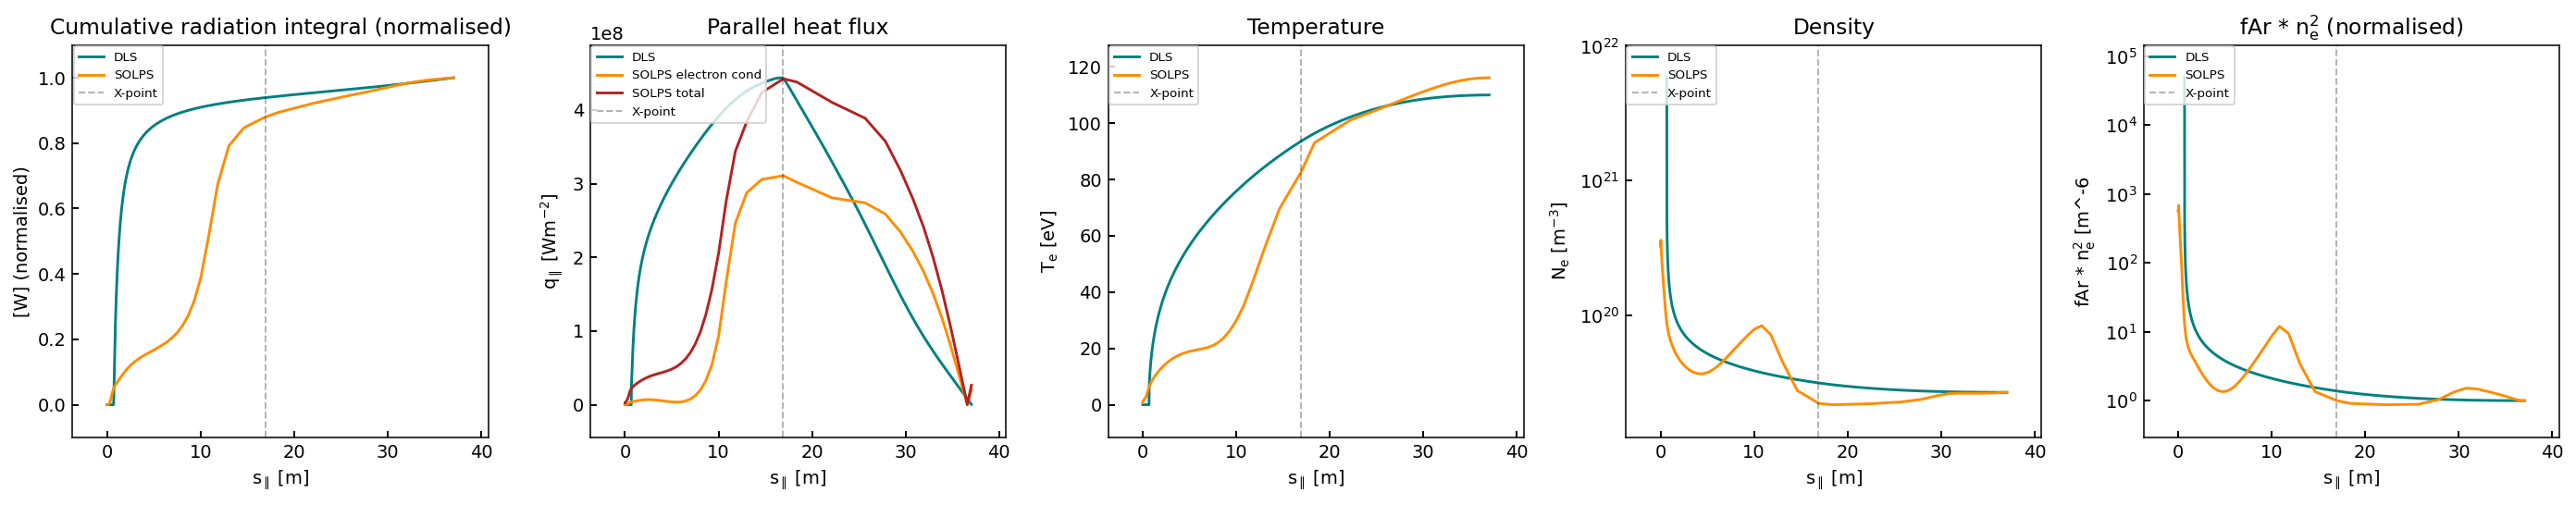

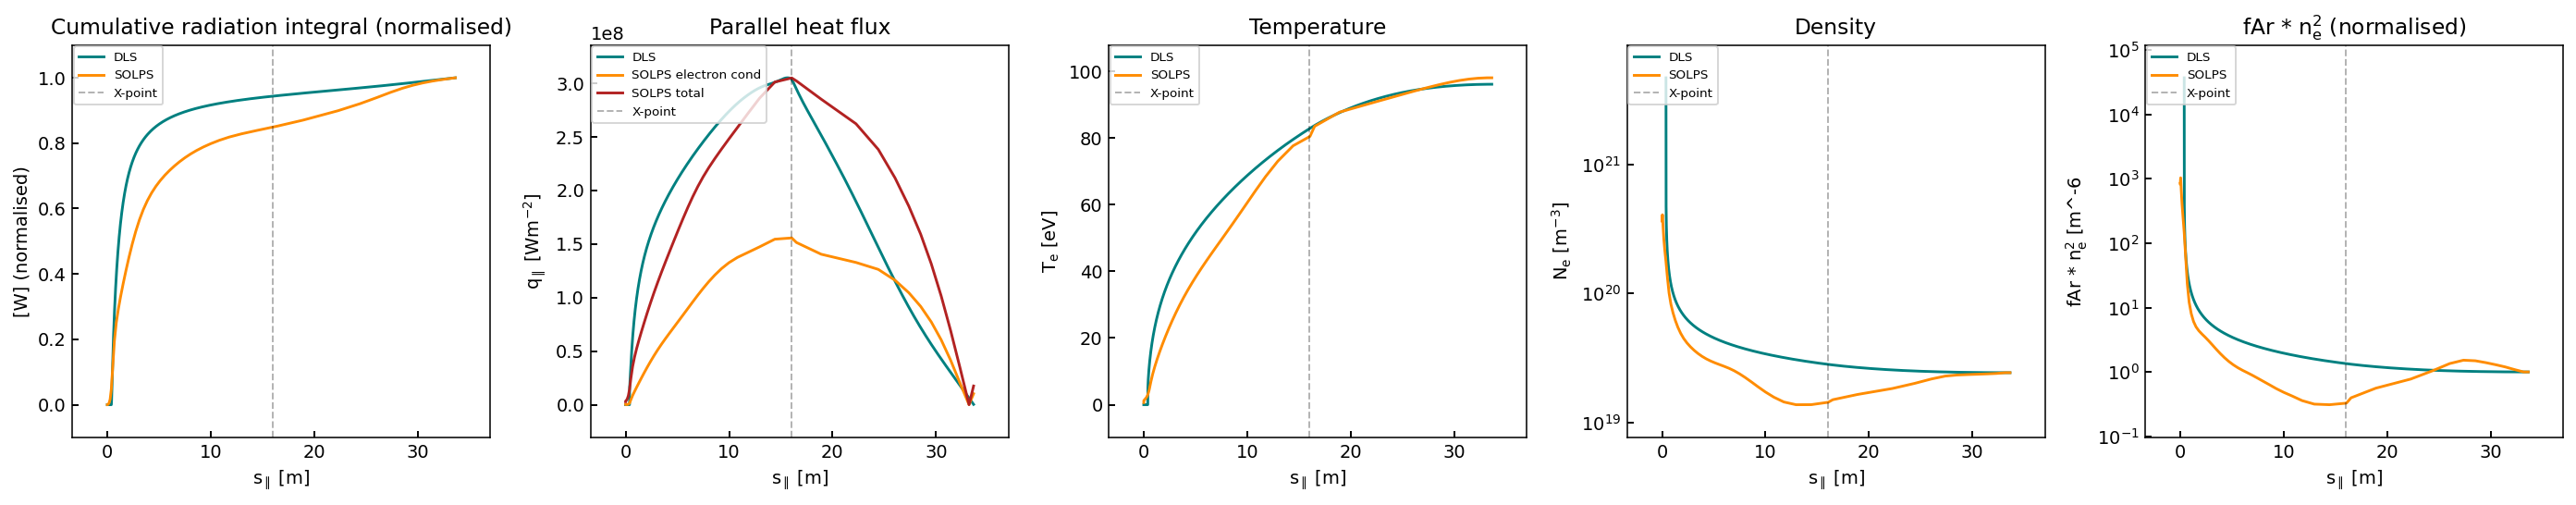

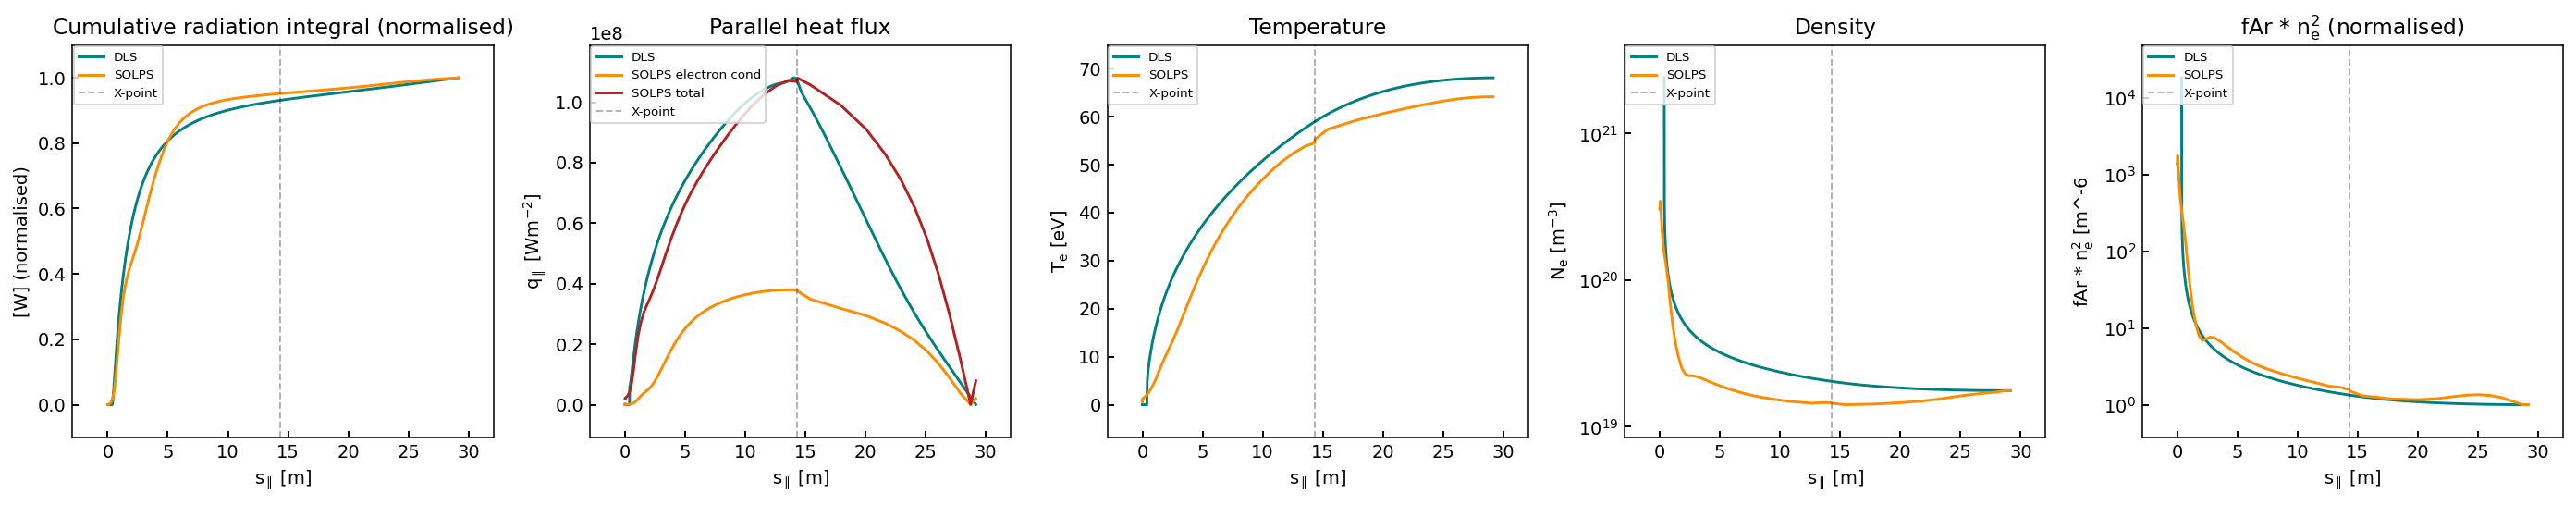

In [12]:
study = "adas_curve"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = {0: 1.40, 1: 1.06, 2: 1.05, 3: 1.03, 4: 1.06}

for i in [1,2,4]:
    input = {
        "cooling_curve" : curves["Ar"][5e19],
        "kappa0" : 2500
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"    Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### With fitted curve

Solving...0.68...Complete in 0.8 seconds
    Hflux factor for sepadd 1: 1.10
Solving...0.38...Complete in 0.7 seconds
    Hflux factor for sepadd 2: 1.08
Solving...0.37...Complete in 0.8 seconds
    Hflux factor for sepadd 4: 1.00


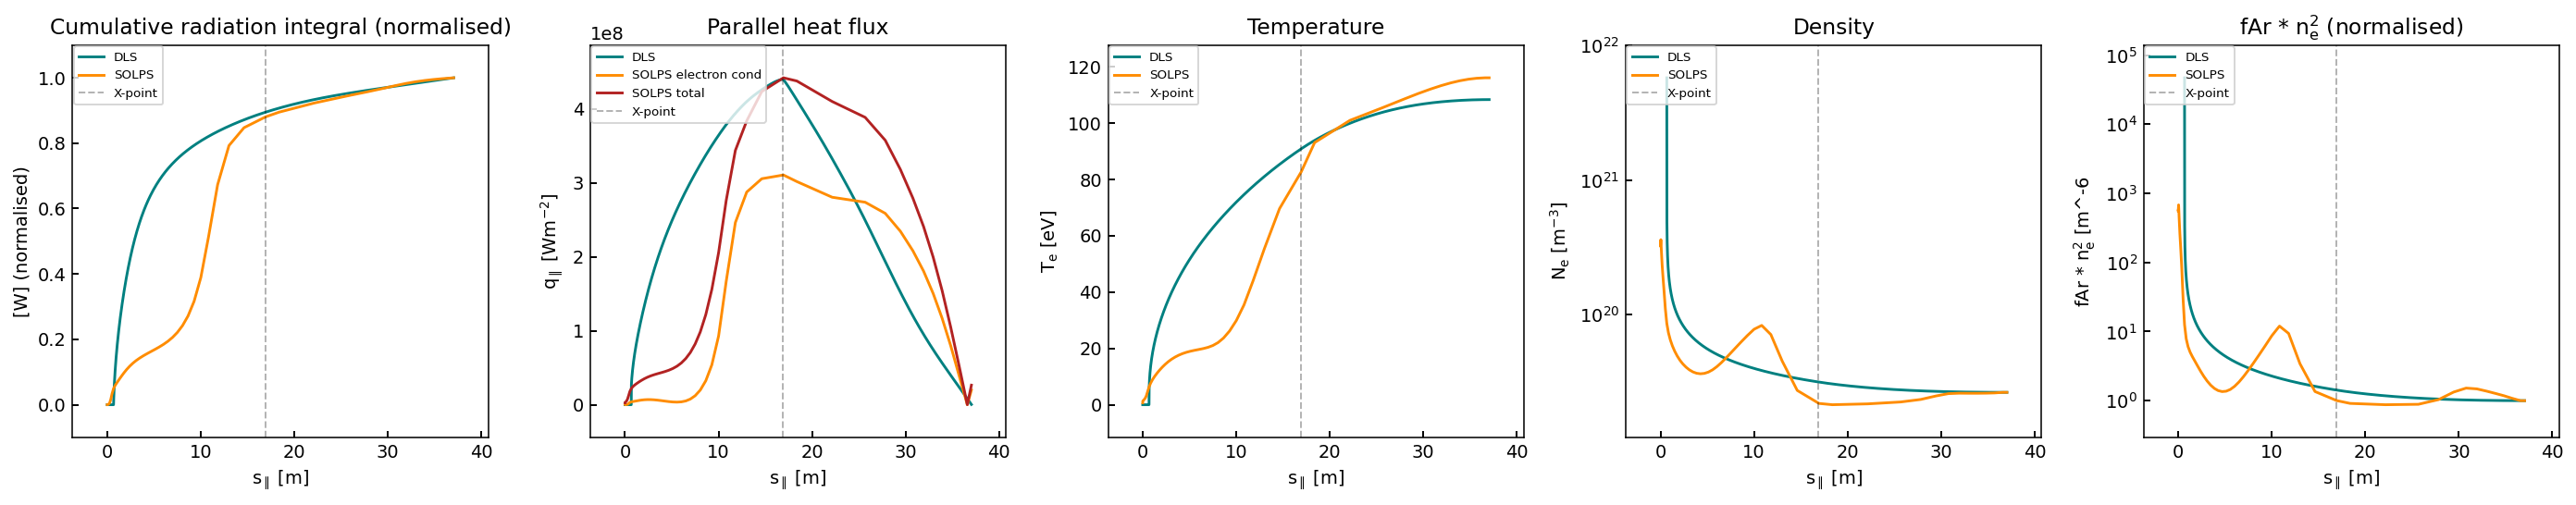

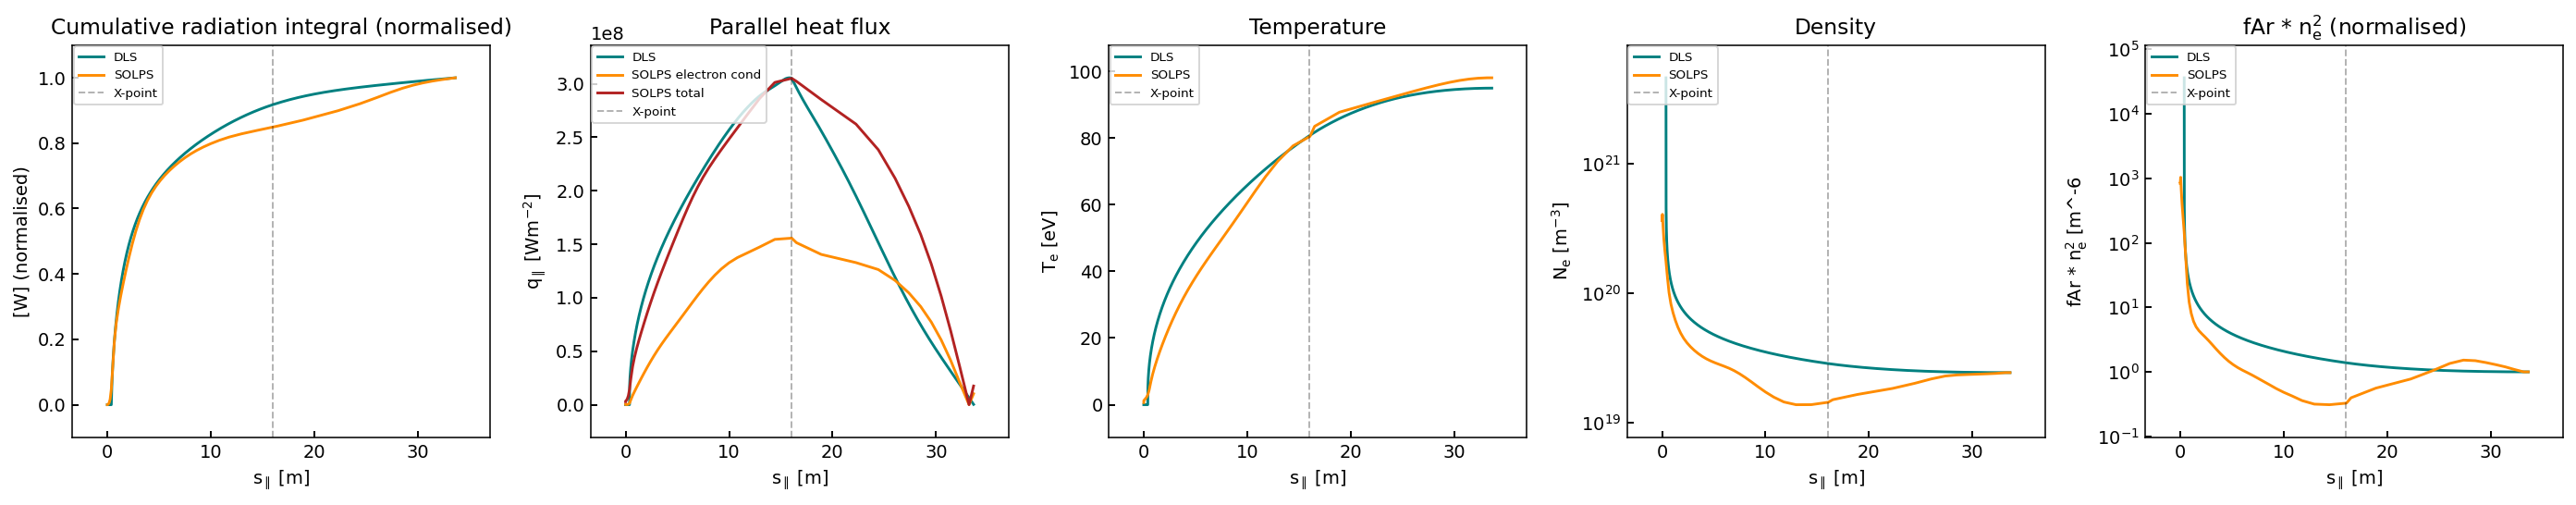

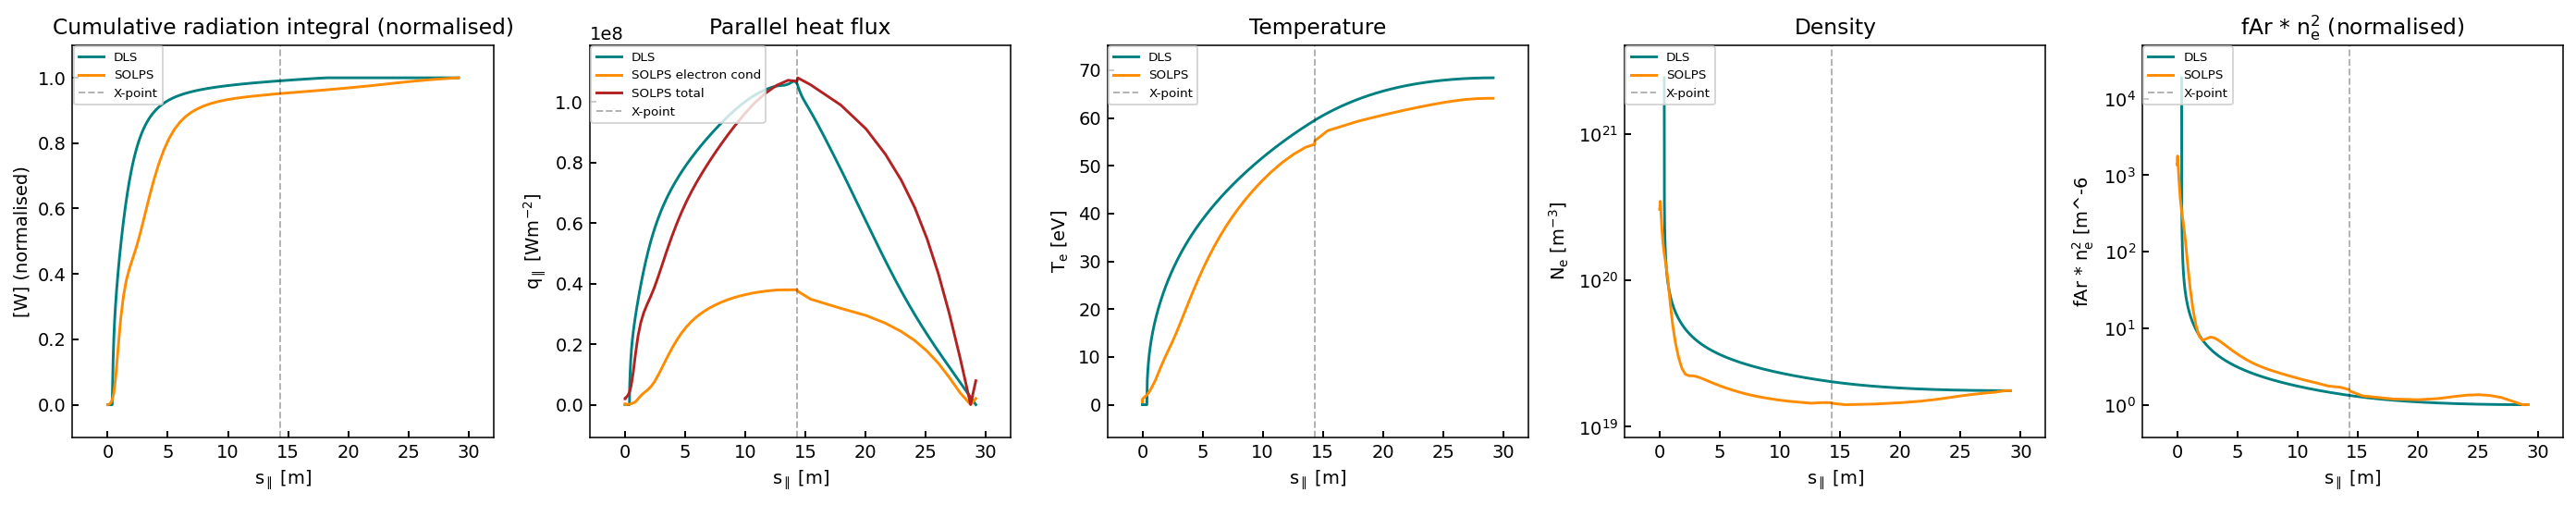

In [13]:
study = "fit_curve"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = {0: 1.40, 1: 1.10, 2: 1.08, 3: 1.00, 4: 0.99}

for i in [1,2,4]:
    input = {
        "cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"    Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### Fit curve, fit kappa

In [14]:
2500*0.9

2250.0

Solving...0.68...Complete in 0.3 seconds
  Hflux factor for sepadd 1: 1.04
  Kappa factor for sepadd 1: 0.77
Solving...0.38...Complete in 0.8 seconds
  Hflux factor for sepadd 2: 1.06
  Kappa factor for sepadd 2: 0.90
Solving...0.37...Complete in 0.4 seconds
  Hflux factor for sepadd 4: 1.01
  Kappa factor for sepadd 4: 1.26


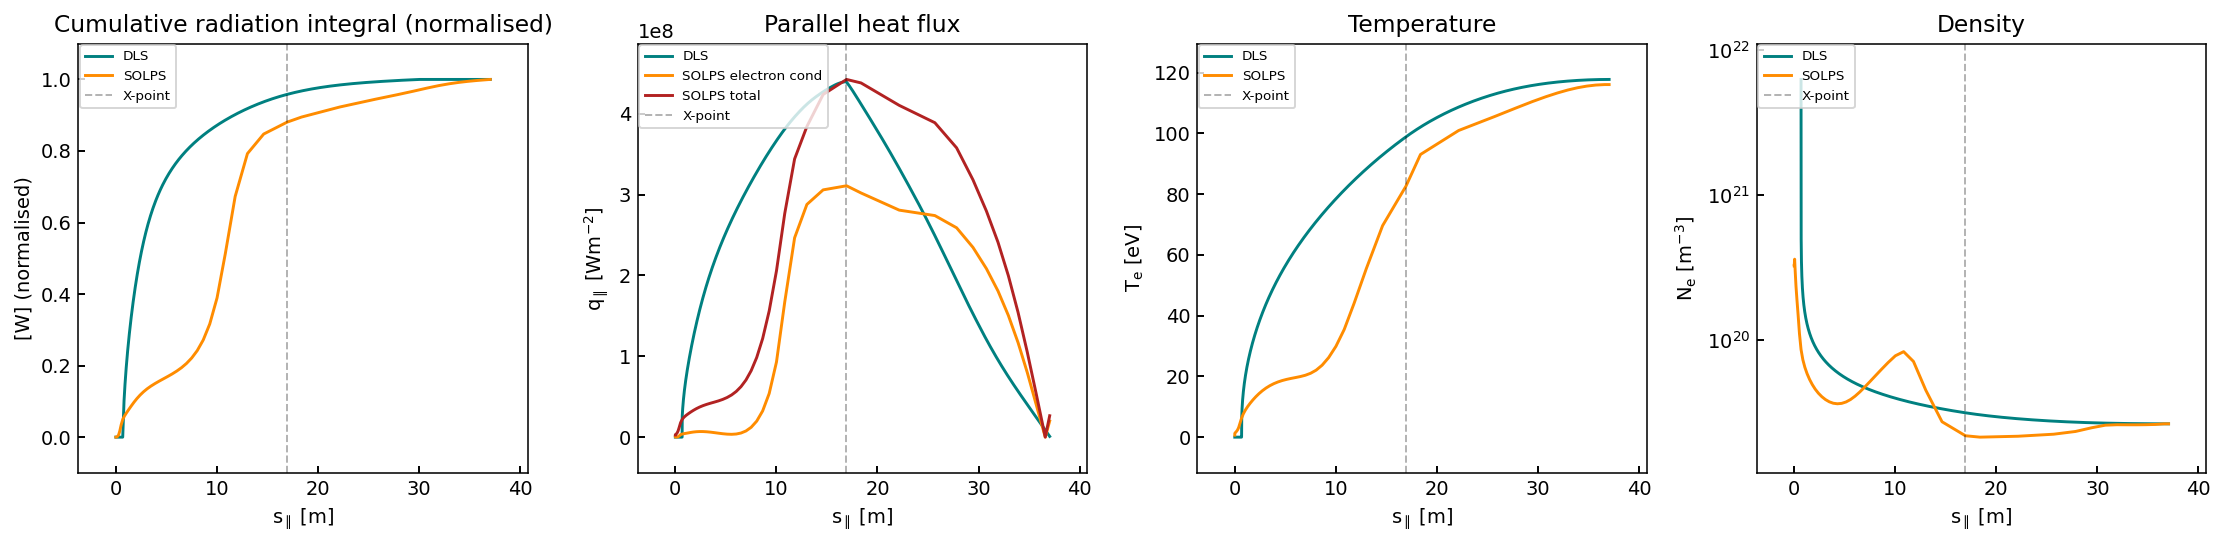

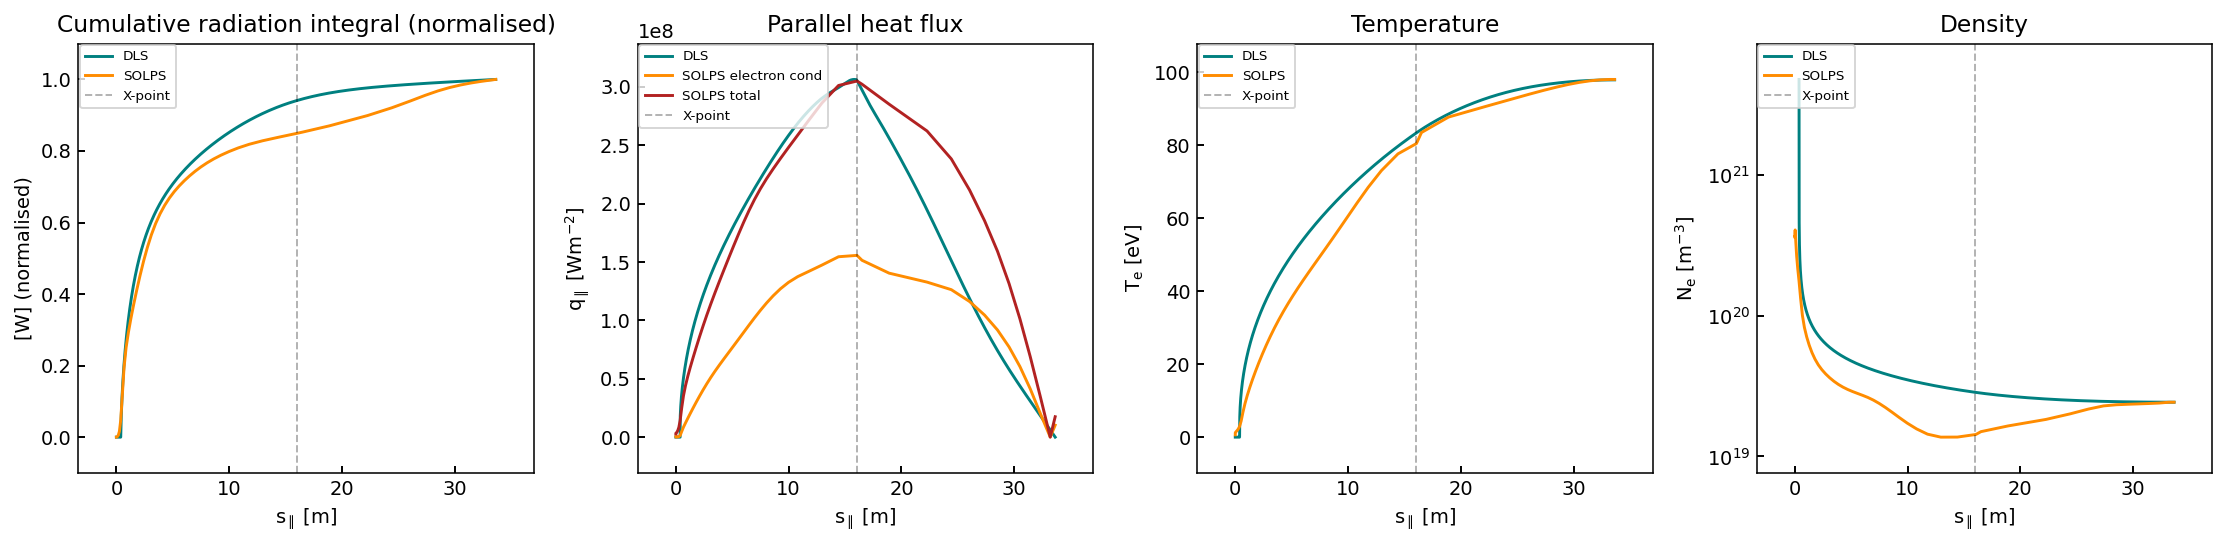

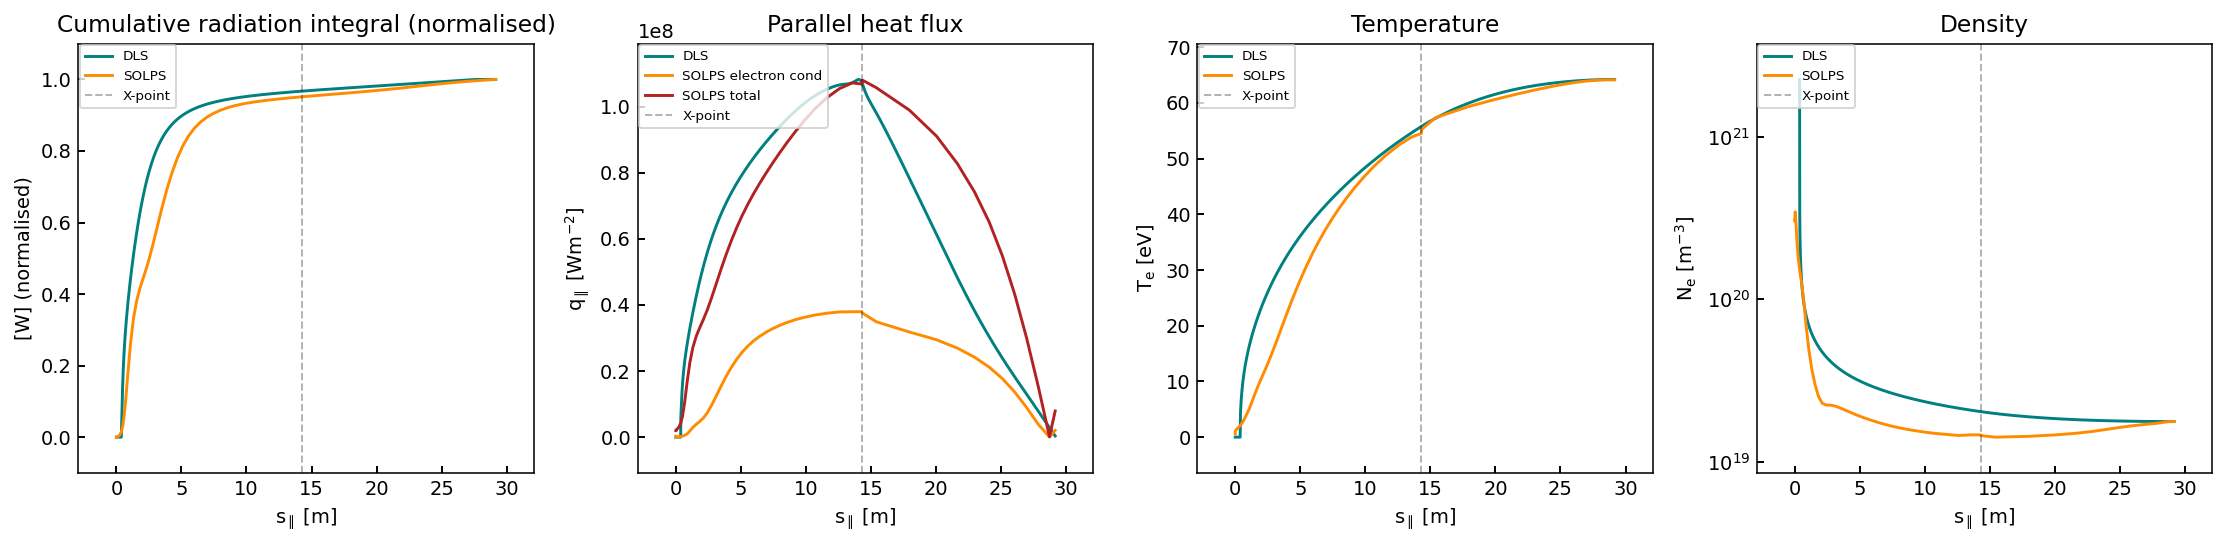

In [15]:
study = "fit_curve_kappa"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = [1.03, 1.06, 1.02]
kappa_corrections = [0.75, 0.90, 1.26]

for idx, i in enumerate([1,2,4]):
    input = {
        "cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        # "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region, total_hflux = True, skip_xpoint = False, print_kappa = True),
        "kappa0" : 2500 * kappa_corrections[idx]
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[idx])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[idx]:.2f}")
    print(f"  Kappa factor for sepadd {i}: {kappa_factor * kappa_corrections[idx]:.2f}")


In [16]:
comps_outer.keys()

dict_keys(['adas_curve', 'fit_curve', 'fit_curve_kappa'])

## Plot

In [17]:
comps_outer.keys()

dict_keys(['adas_curve', 'fit_curve', 'fit_curve_kappa'])

### Synopsis plots

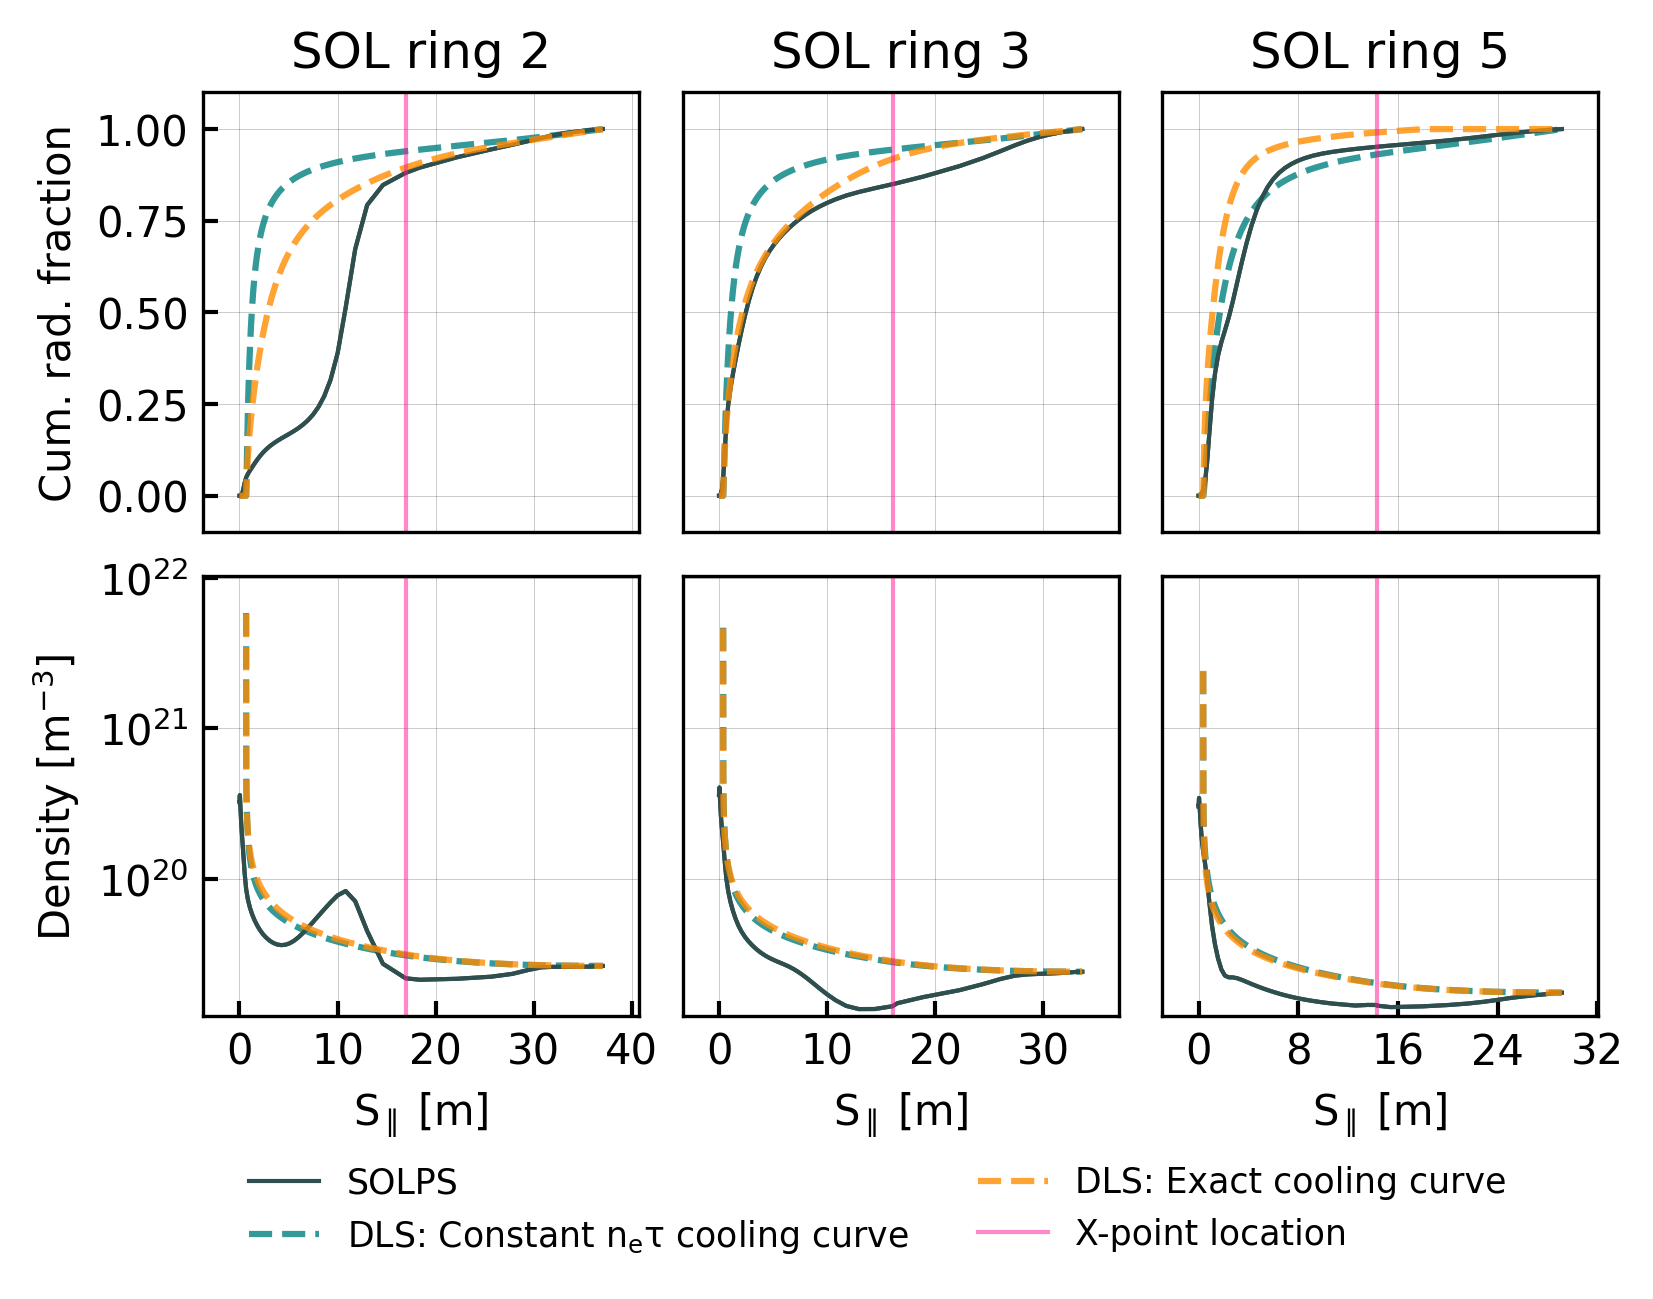

In [20]:
fig, axes = plt.subplots(2, 3, figsize = (6,4), dpi = 300, sharey = False)

study_choice = ['adas_curve', 'fit_curve']
pc = plot_comparison(comps_outer, studies = study_choice)
pc.plot("Qrad_cum_norm", axes[0,:])
pc.plot("Ne", axes[1,:])

axes[0,0].set_title("SOL ring 2")
axes[0,1].set_title("SOL ring 3")
axes[0,2].set_title("SOL ring 5")

handles = pc.make_legend_elements()
handles_xpoint = [pc.make_legend_elements()[-1]]

for i in [1,2,3]:
    handles[i].set_label("DLS: " + handles[i].get_label())
handles[-1].set_label("X-point location")

axes[0,0].set_ylabel("Cum. rad. fraction")
axes[1,0].set_ylabel("Density [$m^{-3}$]")

for row in range(2):
    for col in [1,2]:
        axes[row, col].sharey(axes[row,0])
        axes[row, col].tick_params(axis="y", left = False, labelleft = False)
        axes[row, col].set_ylabel("")
        
for col in range(3):
    axes[0, col].set_xlabel("")
    axes[0, col].tick_params(axis = "x", bottom = False, labelbottom = False)
# axes[0,1].get_shared_y_axes().join(axes[0,0], axes[0,1])

voffset = 0.2
fig.legend(handles = handles, ncols = 2, bbox_to_anchor = (0.5, -0.2 + voffset), loc = "upper center", frameon = False, fontsize = "small")
# fig.legend(handles = handles_xpoint, ncols = 1, bbox_to_anchor = (0.073, -0.45 + voffset), loc = "upper left", frameon = False)
fig.subplots_adjust(wspace = 0.1)
fig.subplots_adjust(hspace = 0.1)

In [ ]:
comps_outer["adas_curve"].keys()

dict_keys(['adas_curve', 'fit_curve', 'fit_curve_kappa'])

In [18]:
comps_abridged = {}

for curve_name in comps_outer.keys():
    # if curve_name
    comps_abridged[curve_name] = {}
    for sepadd in comps_outer[curve_name]:
        if sepadd == 2:
            comps_abridged[curve_name][sepadd] = comps_outer[curve_name][sepadd]

[<Axes: > <Axes: >]


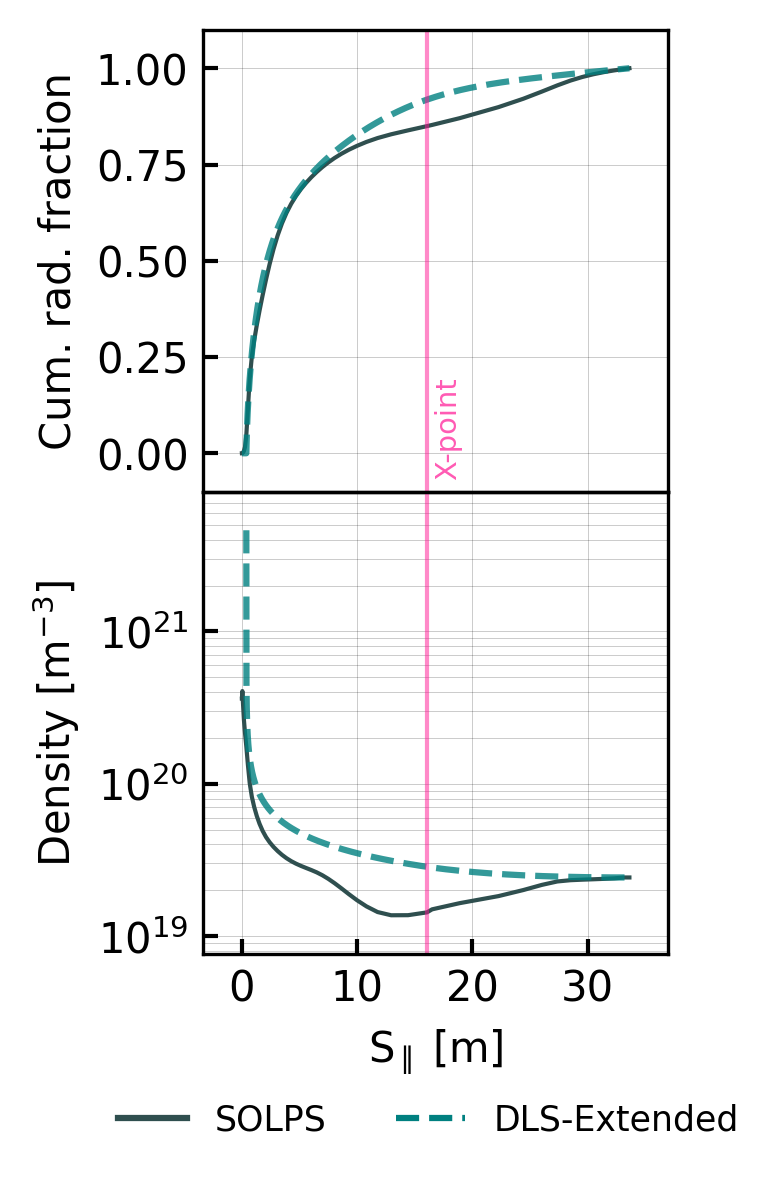

In [66]:
fig, axes = plt.subplots(2,1, figsize = (2,4), dpi = 300, sharex = True)

study_choice = ['fit_curve']
pc = plot_comparison(comps_abridged, studies = study_choice)

print(axes)
pc.plot("Qrad_cum_norm", [axes[0]])
pc.plot("Ne", [axes[1]])


axes[0].set_ylabel("Cum. rad. fraction")
axes[1].set_ylabel("Density [$m^{-3}$]")

axes[0].set_xlabel("")
axes[0].tick_params(axis = "x", bottom = False, labelbottom = False)

simple_legend = [
    mpl.lines.Line2D([0],[0], label = "SOLPS", c = "darkslategrey"),
    mpl.lines.Line2D([0],[0], color = "teal", ls = "--", label = "DLS-Extended")
    ]

axes[1].text(0.51, 0.51, "X-point", c = "deeppink", 
             transform = fig.transFigure, fontsize = "x-small",
             rotation = 90,
             alpha = 0.7)

voffset = 0.2
fig.legend(handles = simple_legend, ncols = 2, bbox_to_anchor = (0.5, -0.2 + voffset), loc = "upper center", frameon = False, fontsize = "small")
# fig.legend(handles = handles_xpoint, ncols = 1, bbox_to_anchor = (0.073, -0.45 + voffset), loc = "upper left", frameon = False)
fig.subplots_adjust(wspace = 0.1)
fig.subplots_adjust(hspace = 0)

### Full plot

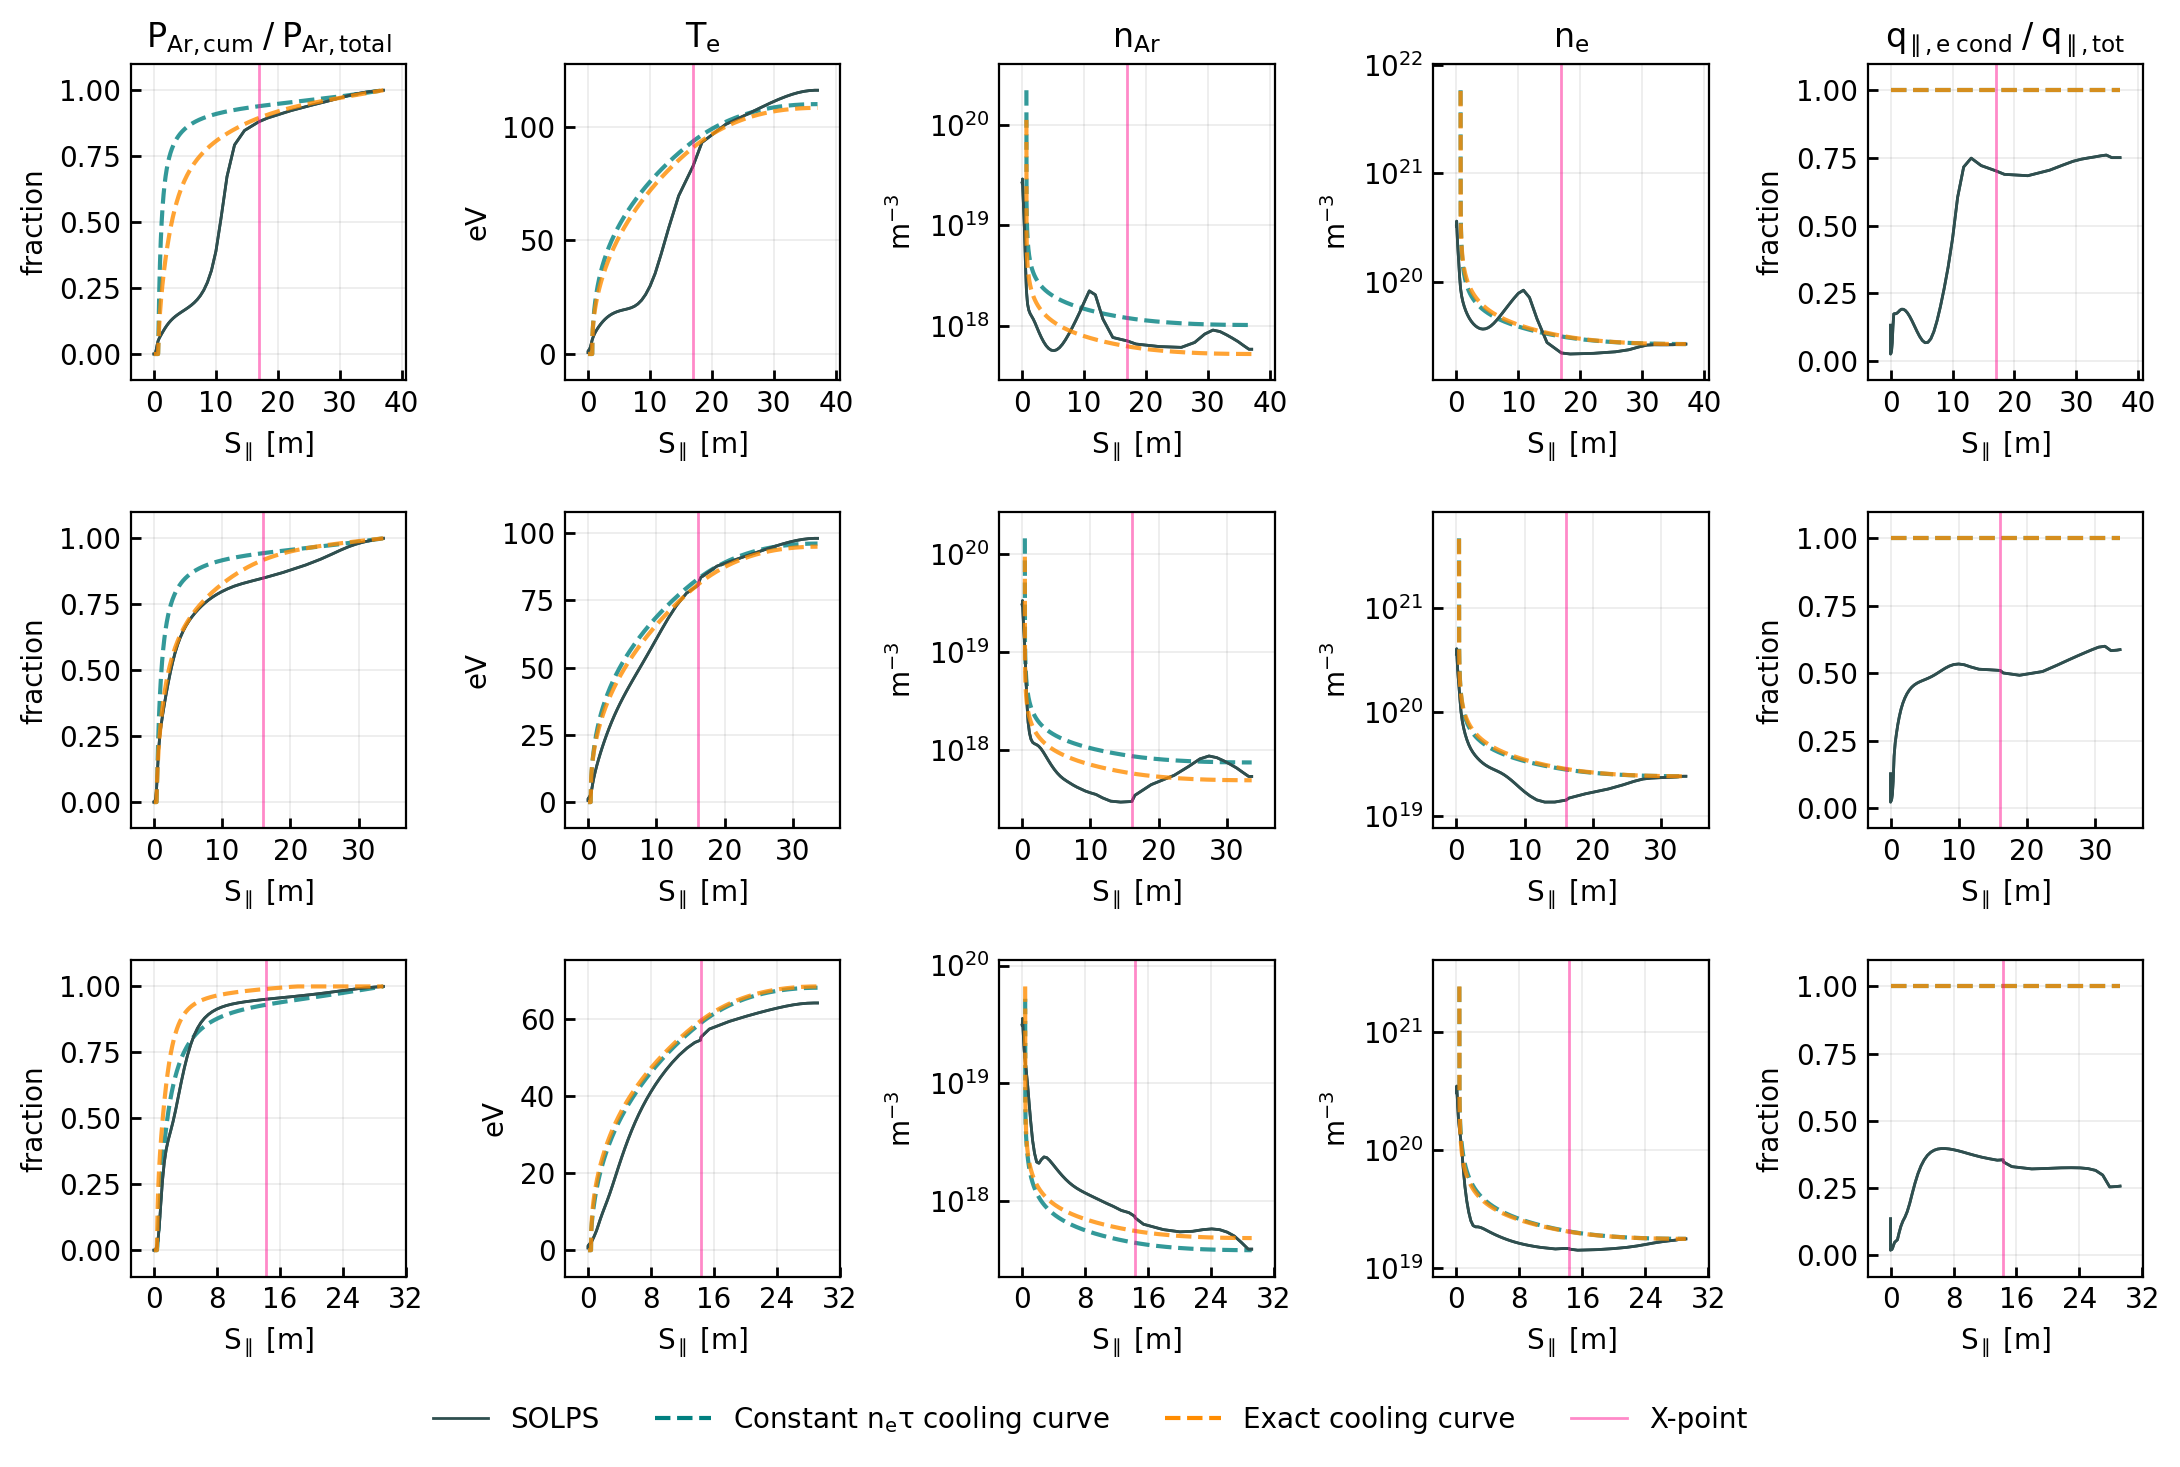

In [14]:
study_choice = ['adas_curve', 'fit_curve']
pc = plot_comparison(comps_outer, studies = study_choice)

param = "Te"

fig, axes = plt.subplots(3, 5, figsize = (11,7), dpi = 200, sharey = False)

pc.plot("Qrad_cum_norm", axes[:,0])
pc.plot("Te", axes[:,1])
# pc.plot("qpar", axes[:,2])
pc.plot("Nz", axes[:,2])
pc.plot("Ne", axes[:,3])
pc.plot("qpar_cond_frac", axes[:,4])
# pc.plot("Ne_sq_cz", axes[:,4], normalise = True)

titlesize = "large"
axes[0,0].set_title(r"$P_{Ar,cum}\ /\ P_{Ar,total}$", fontsize = titlesize)
axes[0,1].set_title(r"$T_e$", fontsize = titlesize)
axes[0,2].set_title(r"$n_{Ar}$", fontsize = titlesize)
axes[0,3].set_title(r"$n_{e}$", fontsize = titlesize)
axes[0,4].set_title(r"$q_{\parallel, e\ cond}\ /\ q_{\parallel, tot}$", fontsize = titlesize)

fig.tight_layout(h_pad = 1.5)
fig.legend(handles = pc.make_legend_elements(), ncols = 2+len(study_choice), bbox_to_anchor = (0.5, 0), loc = "upper center", frameon = False)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_DLSresults_outer.pdf", format = "pdf", bbox_inches = "tight")

# Inner target

In [19]:
comps_inner = {}

### With ADAS curve

Solving...2.52...Complete in 0.8 seconds
  Hflux factor for sepadd 1: 1.06
Solving...0.81...Complete in 0.8 seconds
  Hflux factor for sepadd 2: 1.13
Solving...0.00...Complete in 0.4 seconds
  Hflux factor for sepadd 3: 1.14


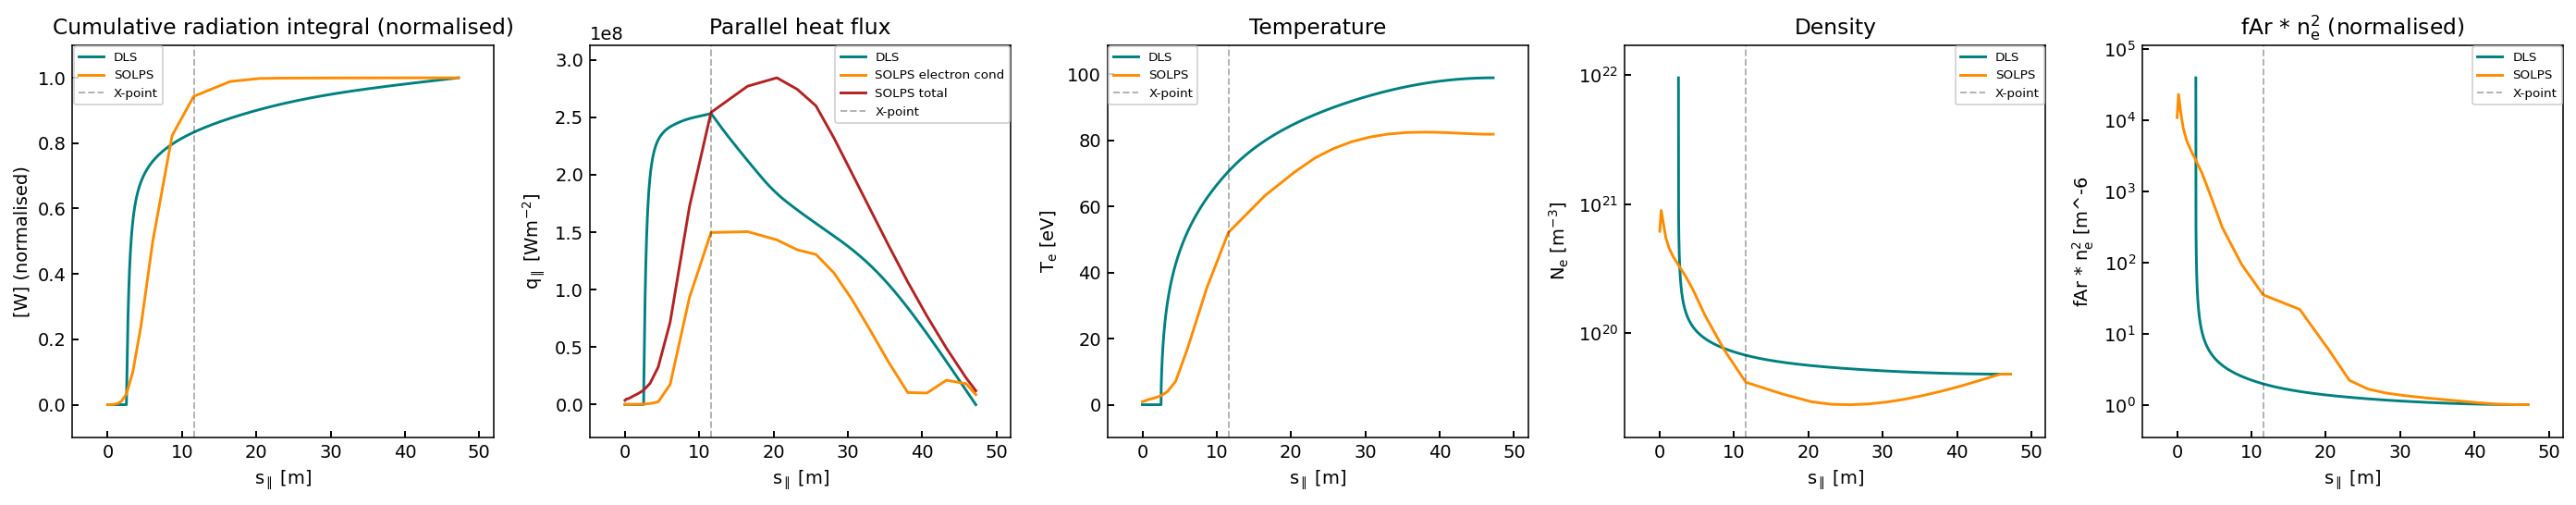

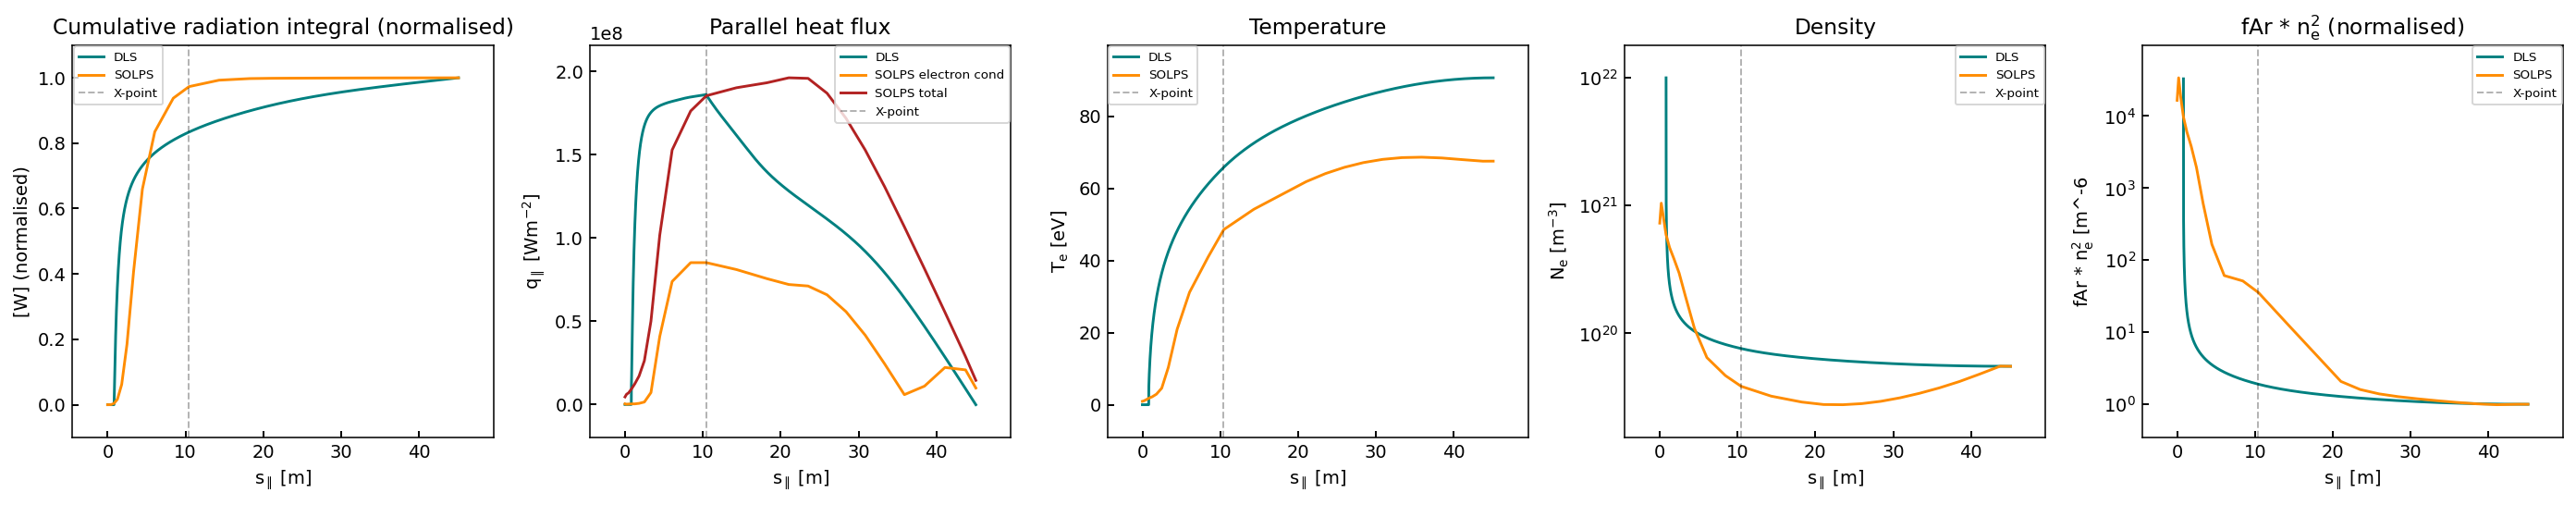

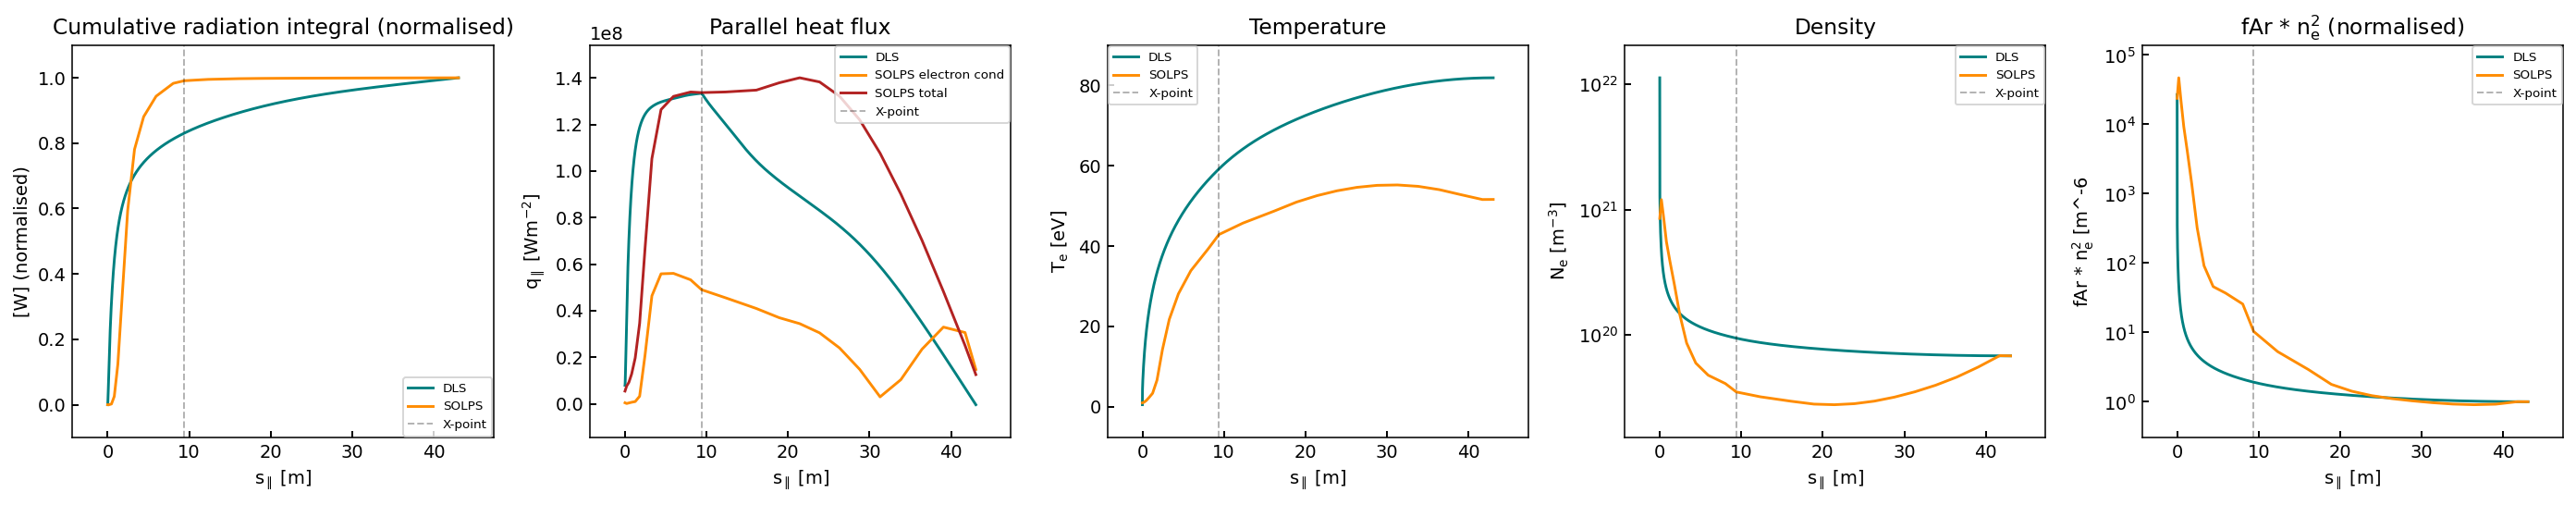

In [20]:
study = "adas_curve"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1, 1: 1.06, 2: 1.13, 3: 1.14, 4: 1.14}
kappa_corrections = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}

for i in [1,2,3]:
    input = {
        # "Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "cooling_curve" : curves["Ar"][1e20],
        "kappa0" : 2500 * kappa_corrections[i],
    }

    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")
    
    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### With fitted curve

Solving...2.52...Complete in 1.0 seconds
  Hflux factor for sepadd 1: 0.92
Solving...0.81...Complete in 0.8 seconds
  Hflux factor for sepadd 2: 0.95
Solving...0.00...Complete in 0.3 seconds
  Hflux factor for sepadd 3: 0.95


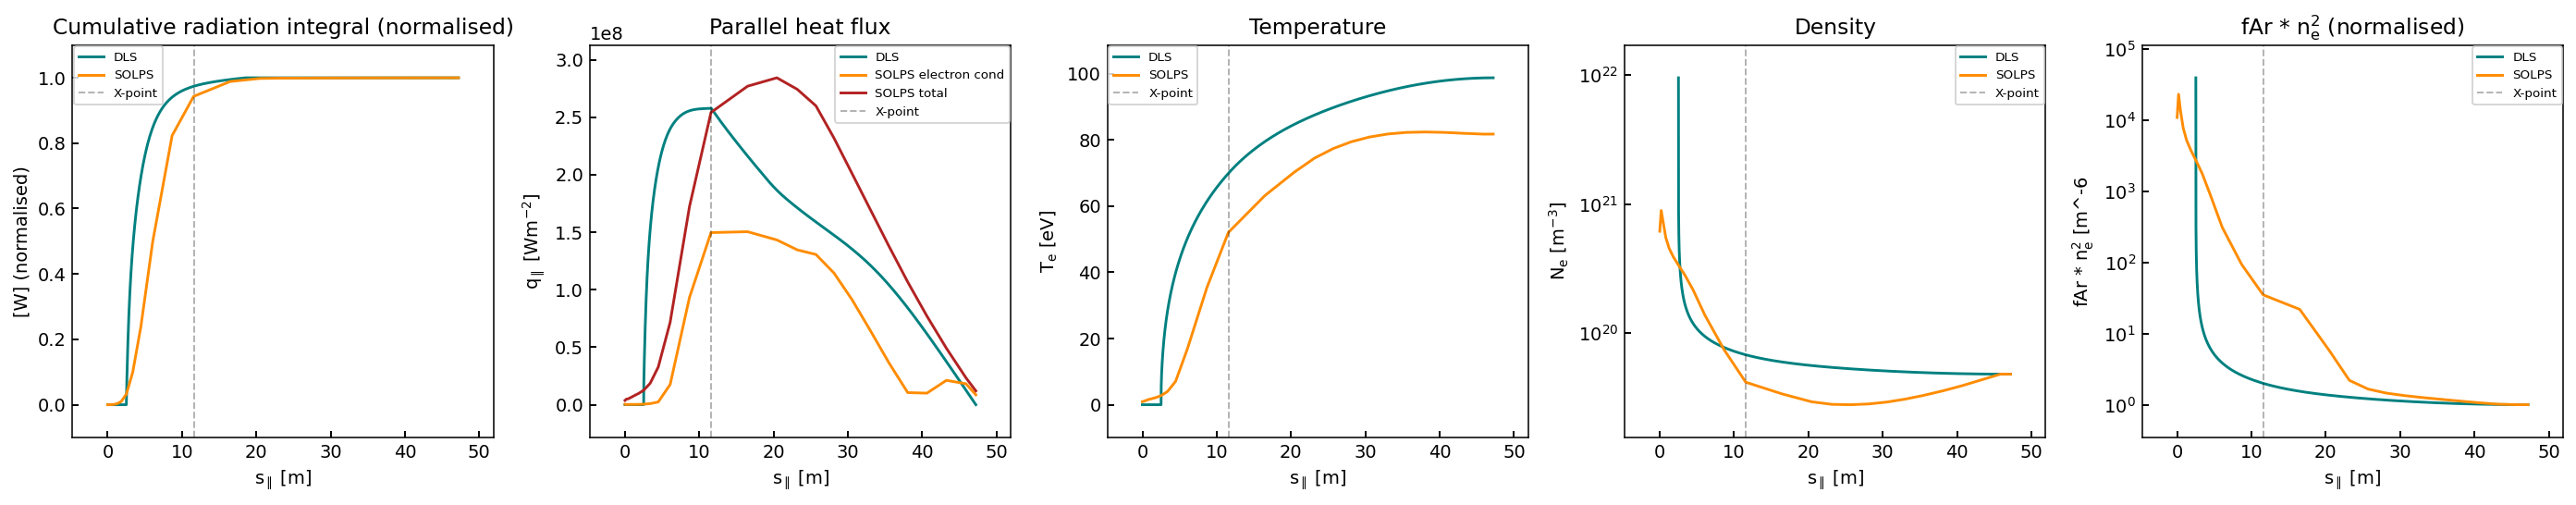

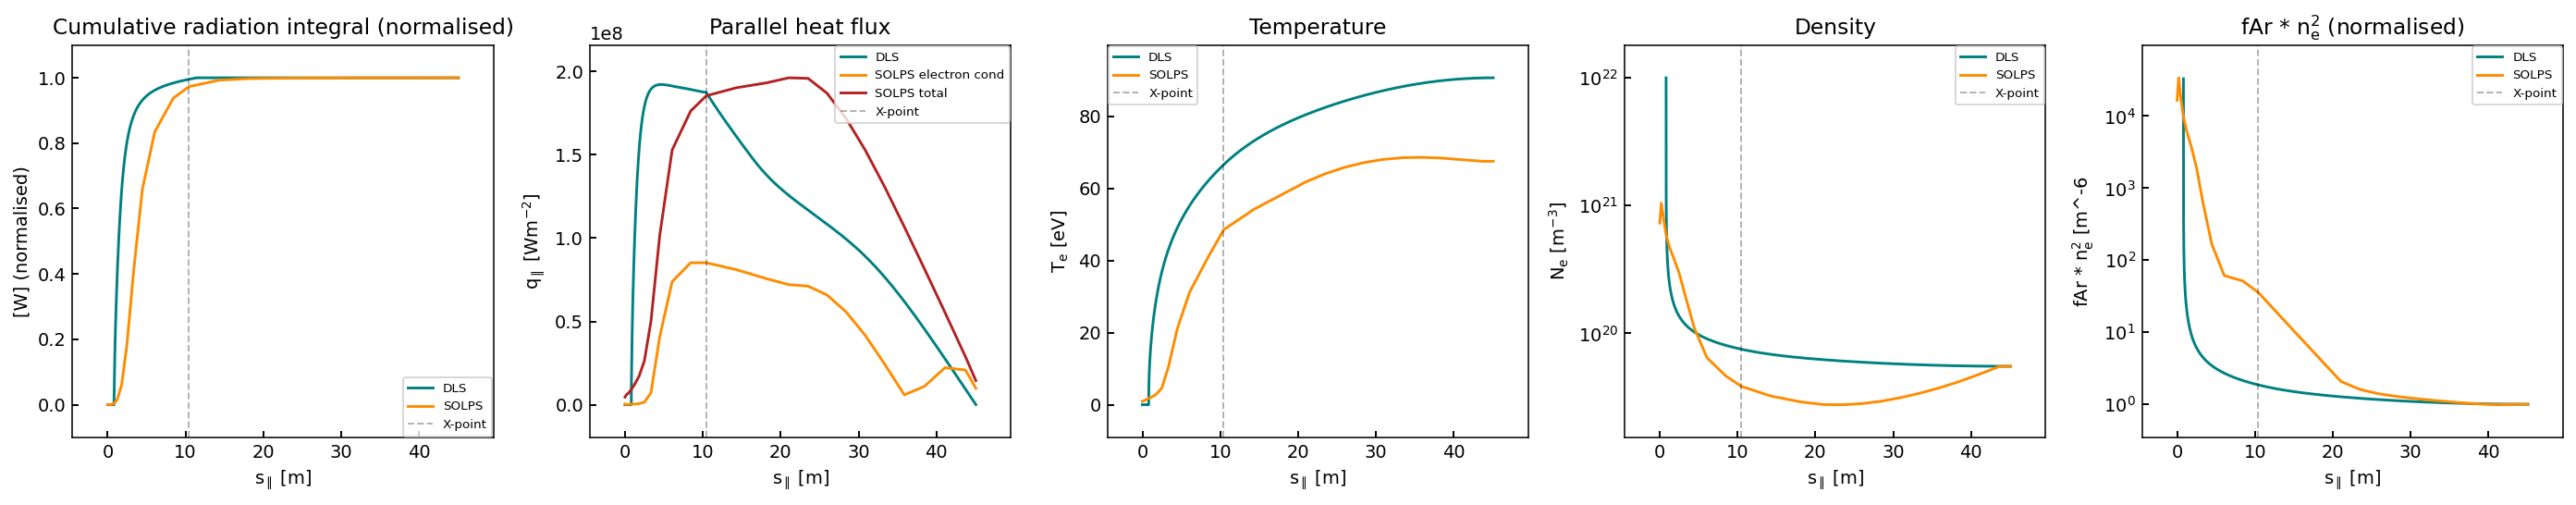

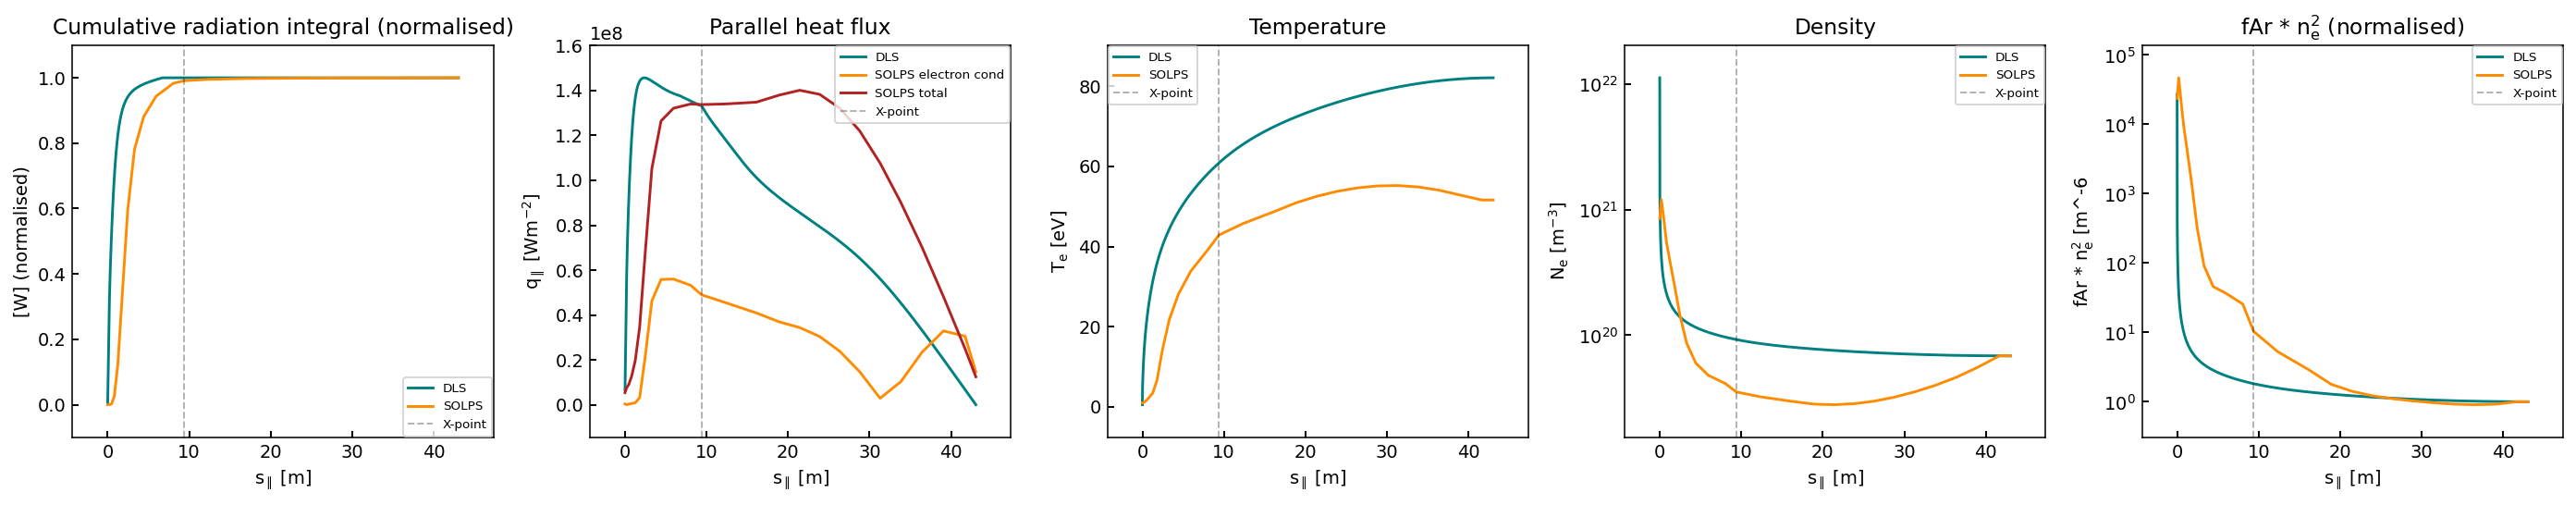

In [21]:
study = "fit_curve"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1, 1: 0.93, 2: 0.96, 3: 0.95, 4: 0.8}
kappa_corrections = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}

for i in [1,2,3]:
    input = {
        "cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500 * kappa_corrections[i],
    }
    
    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")

    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### Fit curve, kappa

In [22]:
2.56 * 2500

6400.0

Solving...2.52...Complete in 0.8 seconds
  Hflux factor for sepadd 1: 0.99
  Kappa factor for sepadd 1: 1.85
Solving...0.81...Complete in 0.5 seconds
  Hflux factor for sepadd 2: 1.03
  Kappa factor for sepadd 2: 2.56
Solving...0.00...Complete in 0.5 seconds
  Hflux factor for sepadd 3: 1.03
  Kappa factor for sepadd 3: 3.84


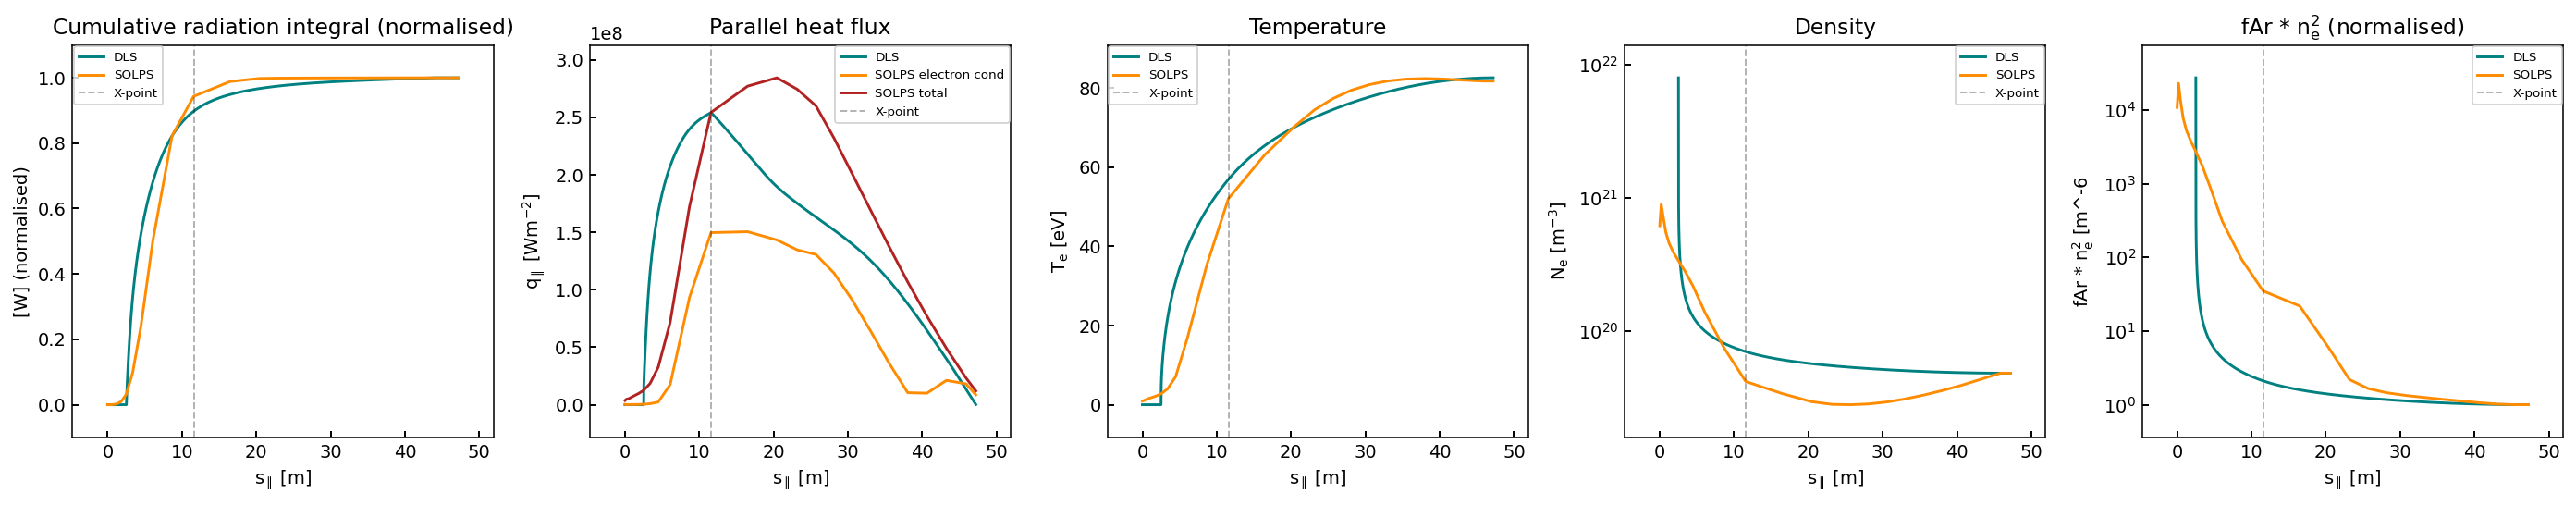

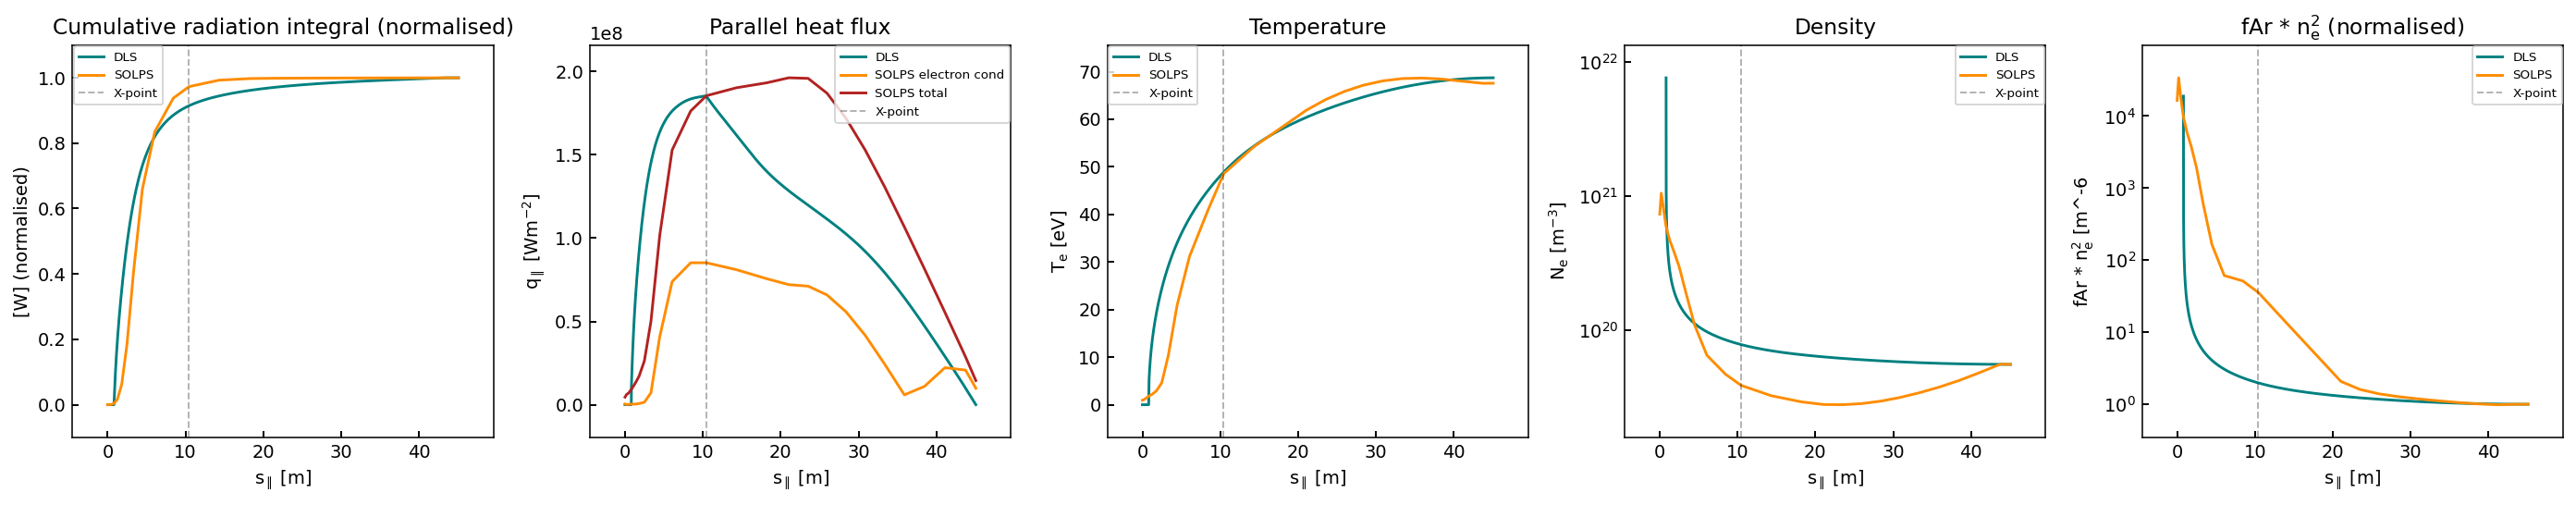

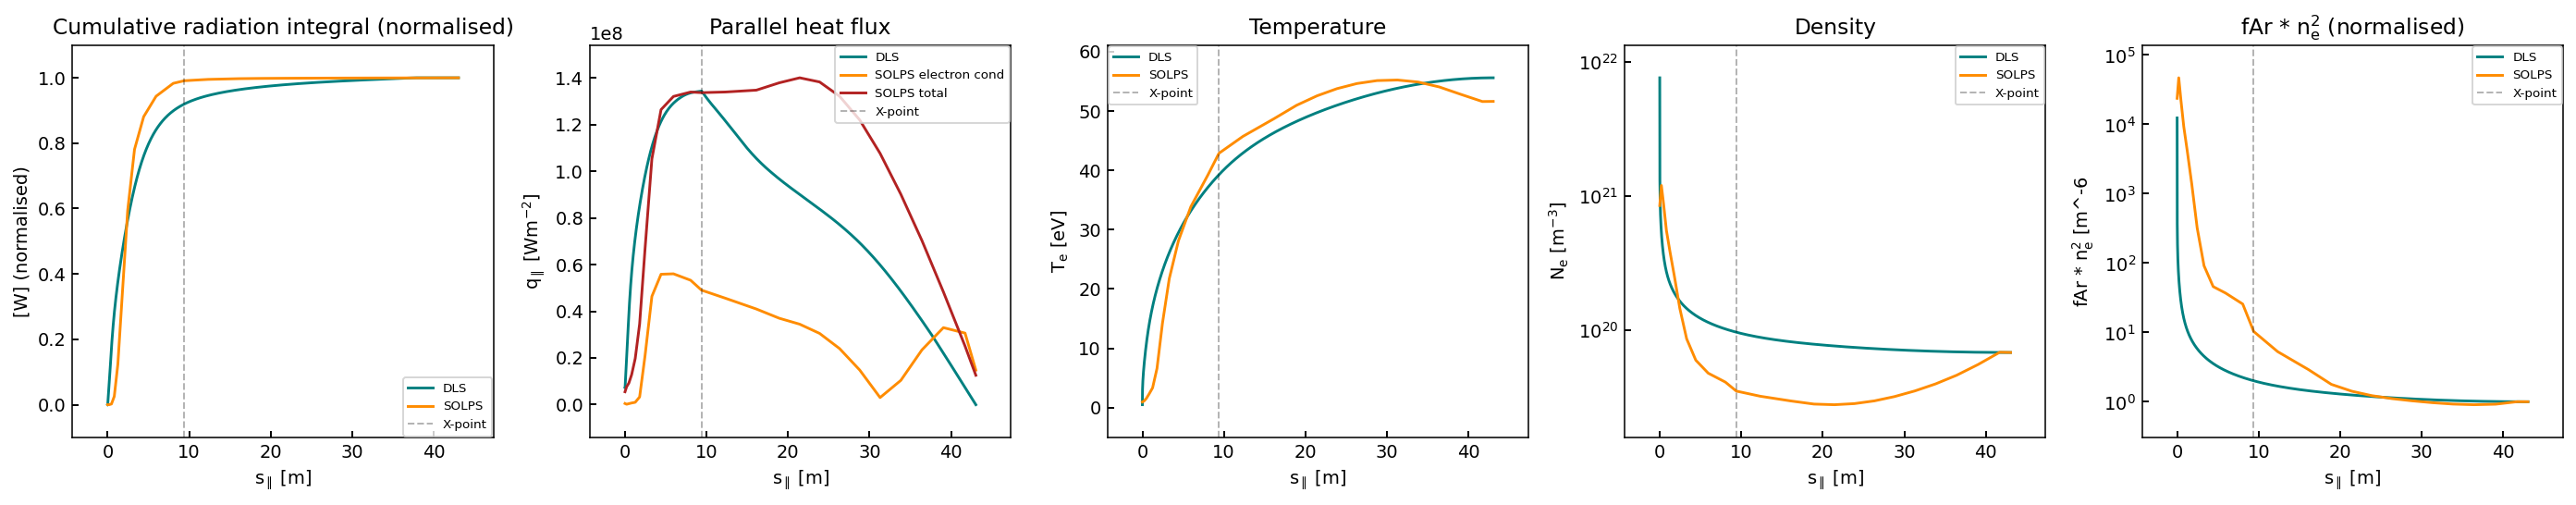

In [23]:
study = "fit_curve_kappa"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1.00, 1: 0.99, 2: 1.03, 3: 1.04, 4: 0.8}
kappa_corrections = {0: 1.13, 1: 1.84, 2: 2.56, 3: 3.79, 4: 3.59}

for i in [1,2,3]:
    input = {
        "cooling_curve" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500 * kappa_corrections[i],
    }

    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")
    
    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")
    print(f"  Kappa factor for sepadd {i}: {kappa_factor * kappa_corrections[i]:.2f}")


## Plot

### Full paper plot

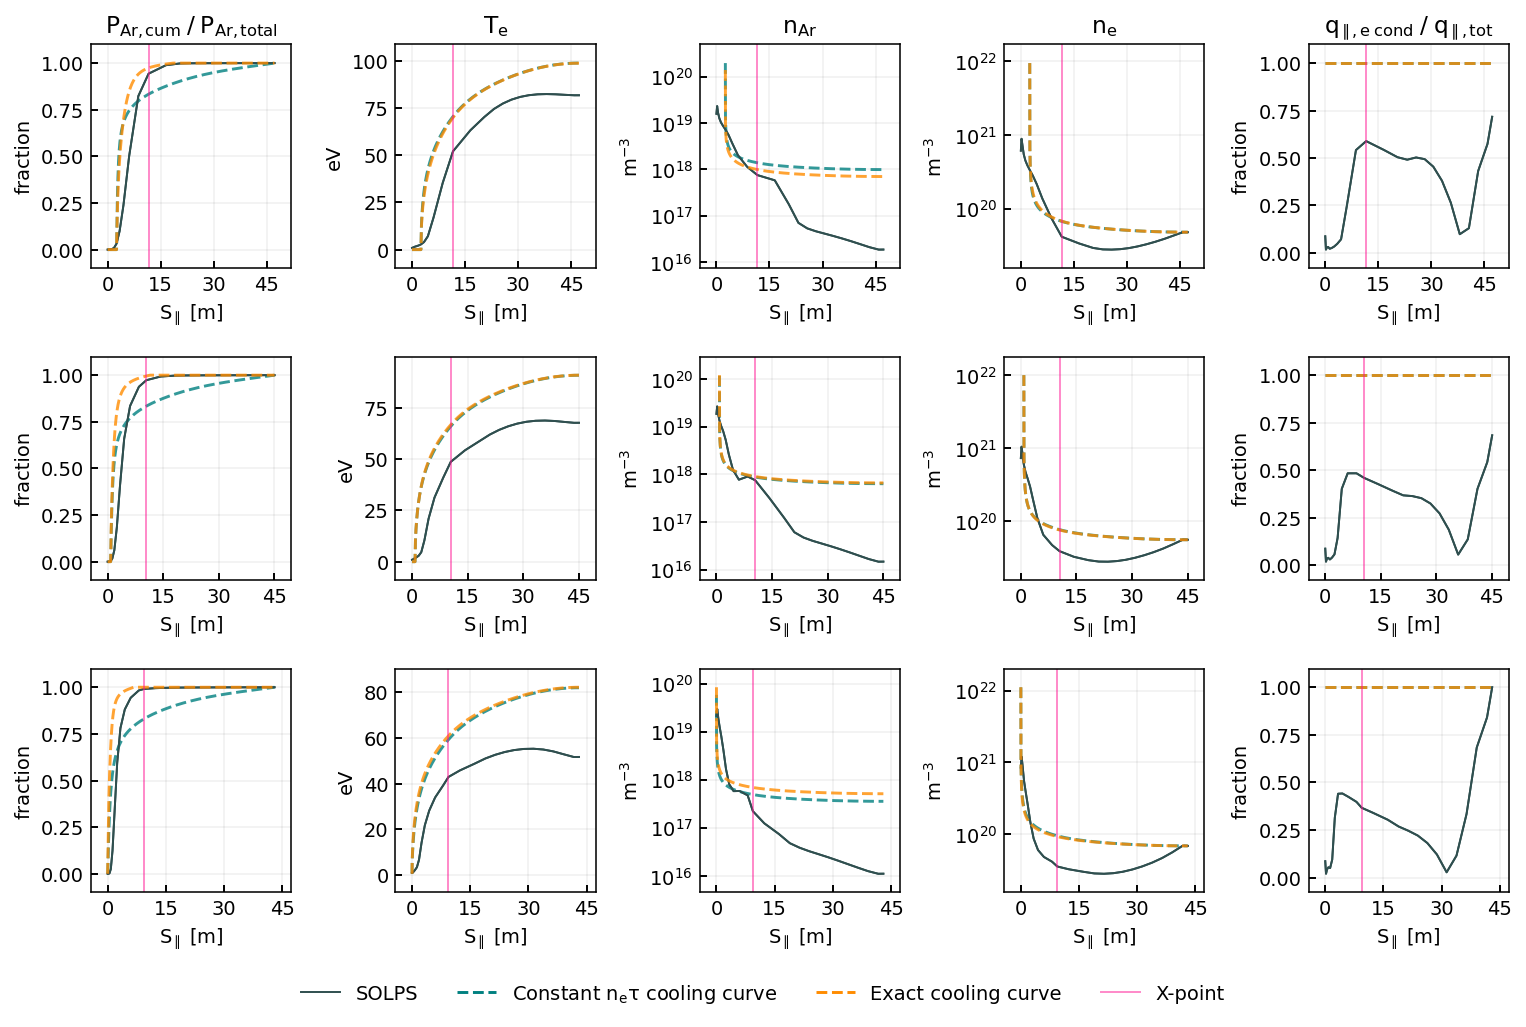

In [18]:
study_choice = ['adas_curve', 'fit_curve']
pc = plot_comparison(comps_inner, studies = study_choice)

param = "Te"

fig, axes = plt.subplots(3, 5, figsize = (11,7), sharey = False)

pc.plot("Qrad_cum_norm", axes[:,0])
pc.plot("Te", axes[:,1])
# pc.plot("qpar", axes[:,2])
pc.plot("Nz", axes[:,2])
pc.plot("Ne", axes[:,3])
pc.plot("qpar_cond_frac", axes[:,4])
# pc.plot("Ne_sq_cz", axes[:,4], normalise = True)

titlesize = "large"
axes[0,0].set_title(r"$P_{Ar,cum}\ /\ P_{Ar,total}$", fontsize = titlesize)
axes[0,1].set_title(r"$T_e$", fontsize = titlesize)
axes[0,2].set_title(r"$n_{Ar}$", fontsize = titlesize)
axes[0,3].set_title(r"$n_{e}$", fontsize = titlesize)
axes[0,4].set_title(r"$q_{\parallel, e\ cond}\ /\ q_{\parallel, tot}$", fontsize = titlesize)

fig.tight_layout(h_pad = 1.5)
fig.legend(handles = pc.make_legend_elements(), ncols = 2+len(study_choice), bbox_to_anchor = (0.5, 0), loc = "upper center", frameon = False)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_DLSresults_inner.pdf", format = "pdf", bbox_inches = "tight")

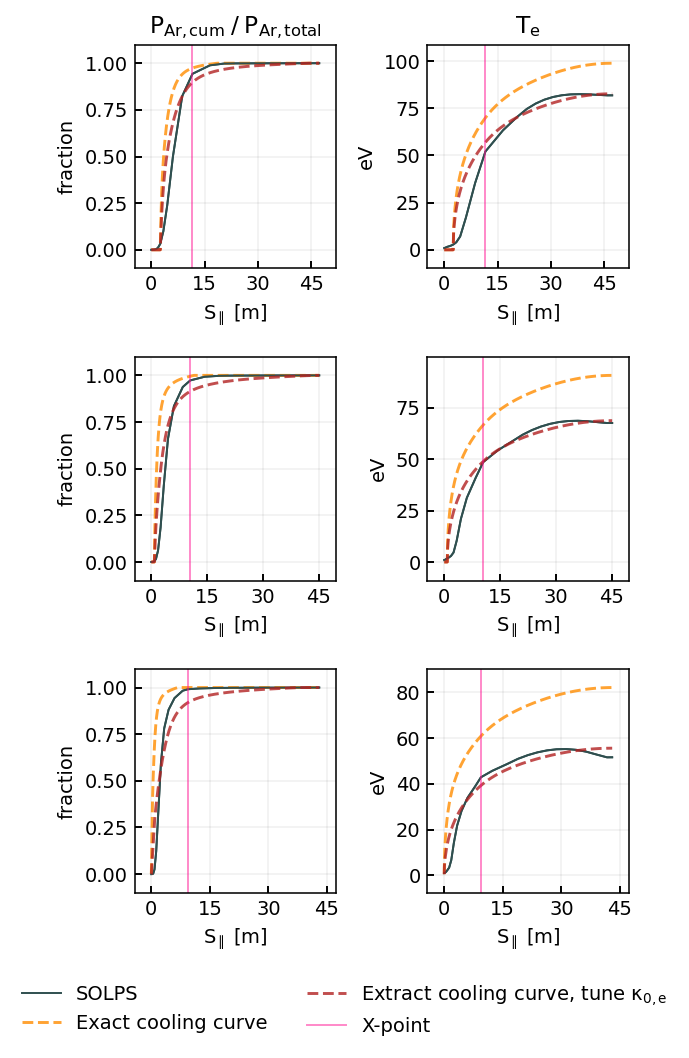

In [52]:
### Conduction study plot

study_choice = ['fit_curve', 'fit_curve_kappa']
pc = plot_comparison(comps_inner, studies = study_choice)

param = "Te"

fig, axes = plt.subplots(3, 2, figsize = (11*2/5,7), sharey = False)

pc.plot("Qrad_cum_norm", axes[:,0])
pc.plot("Te", axes[:,1])
# pc.plot("qpar", axes[:,2])
# pc.plot("Nz", axes[:,2])
# pc.plot("Ne", axes[:,3])
# pc.plot("qpar_cond_frac", axes[:,4])
# pc.plot("Ne_sq_cz", axes[:,4], normalise = True)

titlesize = "large"
axes[0,0].set_title(r"$P_{Ar,cum}\ /\ P_{Ar,total}$", fontsize = titlesize)
axes[0,1].set_title(r"$T_e$", fontsize = titlesize)
# axes[0,2].set_title(r"$n_{Ar}$", fontsize = titlesize)
# axes[0,3].set_title(r"$n_{e}$", fontsize = titlesize)
# axes[0,4].set_title(r"$q_{\parallel, e\ cond}\ /\ q_{\parallel, tot}$", fontsize = titlesize)

fig.tight_layout(h_pad = 1.5)
fig.legend(handles = pc.make_legend_elements(), ncols = 2, bbox_to_anchor = (0.5, 0), loc = "upper center", frameon = False)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_DLSresults_inner_conduction.pdf", format = "pdf", bbox_inches = "tight")

# Paper plots

In [36]:
comps_inner["fit_curve"].keys()

dict_keys([1, 2, 3])

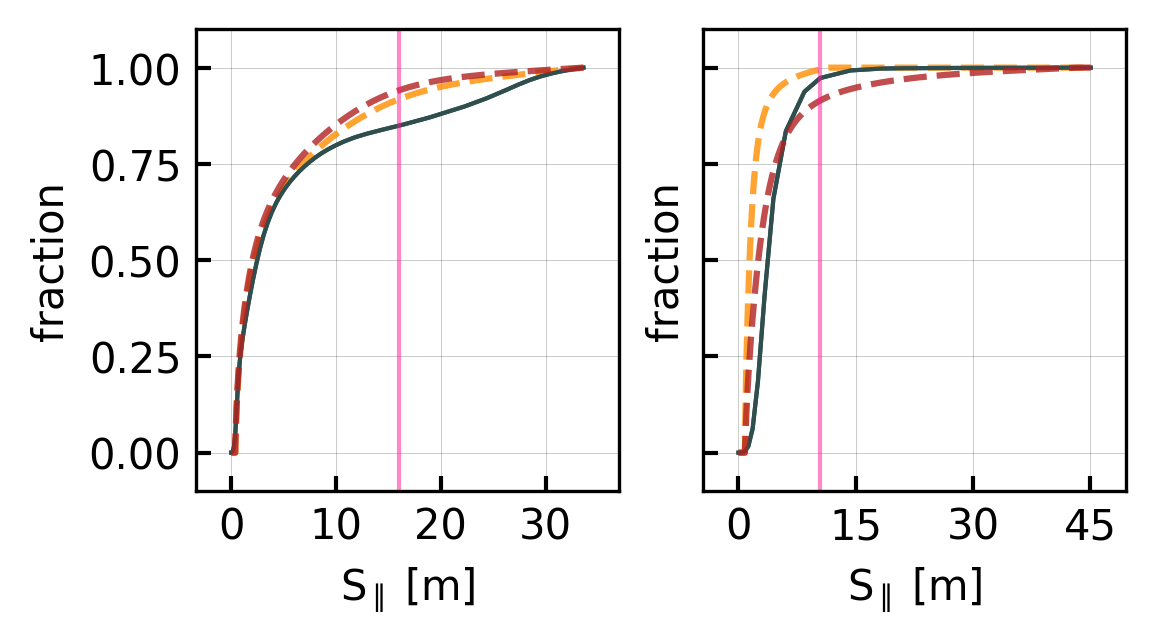

In [ ]:
comps_abridged_outer = {}
comps_abridged_inner = {}

for curve_name in comps_outer.keys():

    comps_abridged_outer[curve_name] = {}
    comps_abridged_inner[curve_name] = {}
    
    for sepadd in comps_outer[curve_name]:
        if sepadd == 2:
            comps_abridged_outer[curve_name][sepadd] = comps_outer[curve_name][sepadd]
            comps_abridged_inner[curve_name][sepadd] = comps_inner[curve_name][sepadd]
            
study_choice = ["fit_curve", "fit_curve_kappa"]

fig, axes = plt.subplots(1,2, figsize = (4,2), dpi = 300, sharey = True)

plot_comparison(comps_abridged_outer, studies = study_choice).plot("Qrad_cum_norm", [axes[0]])
plot_comparison(comps_abridged_inner, studies = study_choice).plot("Qrad_cum_norm", [axes[1]])


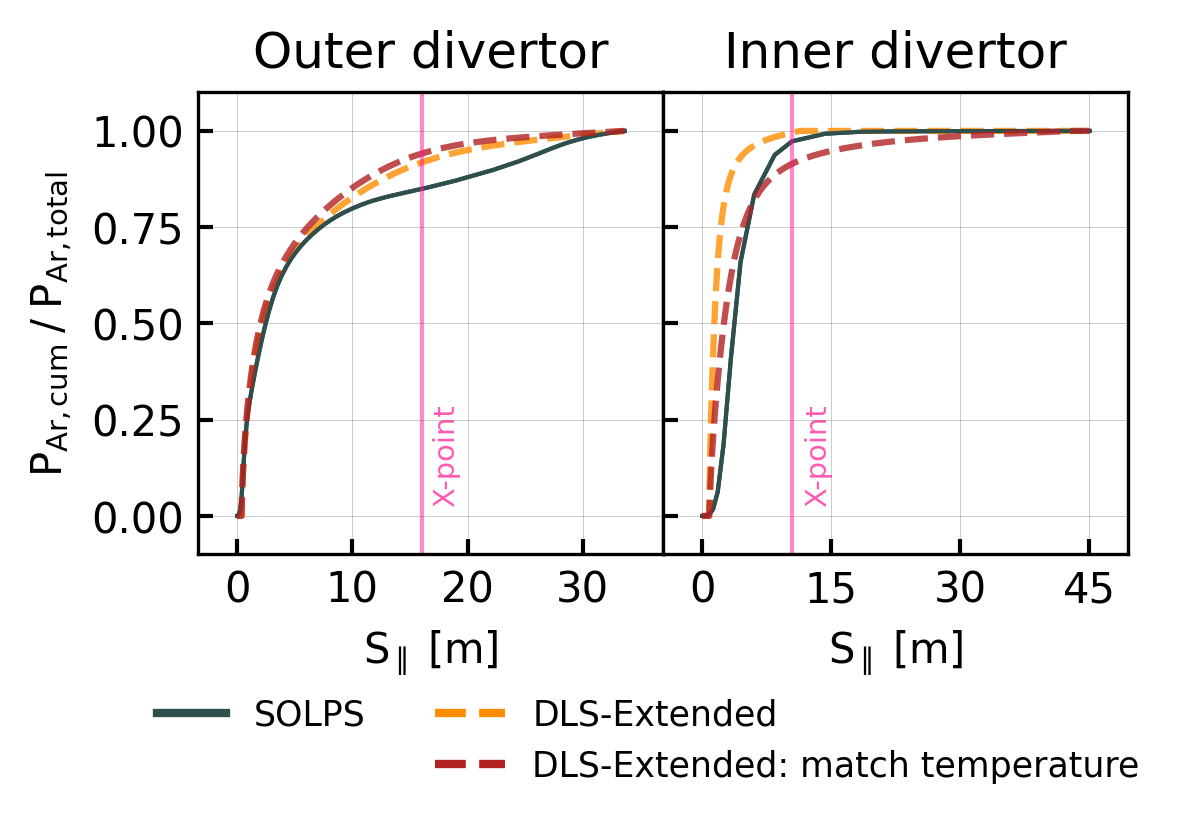

In [ ]:
comps_abridged_outer = {}
comps_abridged_inner = {}

for curve_name in comps_outer.keys():

    comps_abridged_outer[curve_name] = {}
    comps_abridged_inner[curve_name] = {}
    
    for sepadd in comps_outer[curve_name]:
        if sepadd == 2:
            comps_abridged_outer[curve_name][sepadd] = comps_outer[curve_name][sepadd]
            comps_abridged_inner[curve_name][sepadd] = comps_inner[curve_name][sepadd]
            
study_choice = ["fit_curve", "fit_curve_kappa"]

fig, axes = plt.subplots(1,2, figsize = (4,2), dpi = 300, sharey = True)

plot_comparison(comps_abridged_outer, studies = study_choice).plot("Qrad_cum_norm", [axes[0]])
plot_comparison(comps_abridged_inner, studies = study_choice).plot("Qrad_cum_norm", [axes[1]])


axes[0].set_ylabel(r"$P_{Ar,cum}\ /\ P_{Ar,total}$")
# axes[1].set_ylabel("Density [$m^{-3}$]")

axes[1].set_ylabel("")
# axes[0].tick_params(axis = "x", bottom = False, labelbottom = False)
lw = 2
simple_legend = [
    mpl.lines.Line2D([0],[0], label = "SOLPS", lw = 2, c = "darkslategrey"),
    mpl.lines.Line2D([0],[0], c = "white"),
    mpl.lines.Line2D([0],[0], color = "darkorange", ls = "--", lw = 2, label = "DLS-Extended"),
    mpl.lines.Line2D([0],[0], color = "firebrick", ls = "--", lw = 2, label = "DLS-Extended: match temperature")
    ]

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")

axes[1].text(0.32, 0.2, "X-point", c = "deeppink", 
             transform = fig.transFigure, fontsize = "x-small",
             rotation = 90,
             alpha = 0.7)

axes[1].text(0.63, 0.2, "X-point", c = "deeppink", 
             transform = fig.transFigure, fontsize = "x-small",
             rotation = 90,
             alpha = 0.7)

voffset = 0.1
fig.legend(handles = simple_legend, ncols = 2, bbox_to_anchor = (0.5, -0.2 + voffset), loc = "upper center", frameon = False, fontsize = "small")
# fig.legend(handles = handles_xpoint, ncols = 1, bbox_to_anchor = (0.073, -0.45 + voffset), loc = "upper left", frameon = False)
fig.subplots_adjust(wspace = 0)
fig.subplots_adjust(hspace = 0)

plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_DLSresults_summary.pdf", format = "pdf", bbox_inches = "tight")

# 2D plots

KeyError: 'NAr'

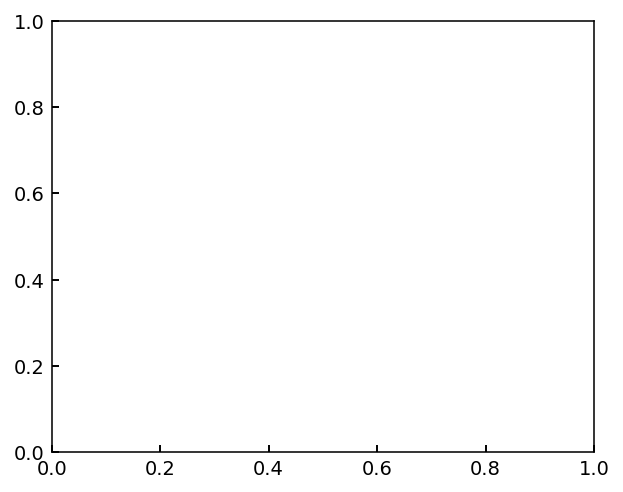

In [29]:
case = "100MW_innerar_midplanepuff"
slc = store_slc[case]

fig, ax = plt.subplots()


slc.plot_2d("NAr", ax = ax)

ax.set_xlim(1, 4.6)
ax.set_ylim(-7, -4)